# This notebook recreates plots in the results section of the paper

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import emcee
import corner
import scipy.stats as sps
from tqdm import trange
from isochrones.mist import MIST_Isochrone
mist = MIST_Isochrone()

from stardate.lhf import convective_overturn_time

plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 30,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Produce plots for the simulated data.

Load the simulated data set.

In [44]:
df = pd.read_csv("data/simulated_data.csv")
true_age_gyr = (10**df.age)*1e-9

Text(0, 0.5, '$\\log(g)$')

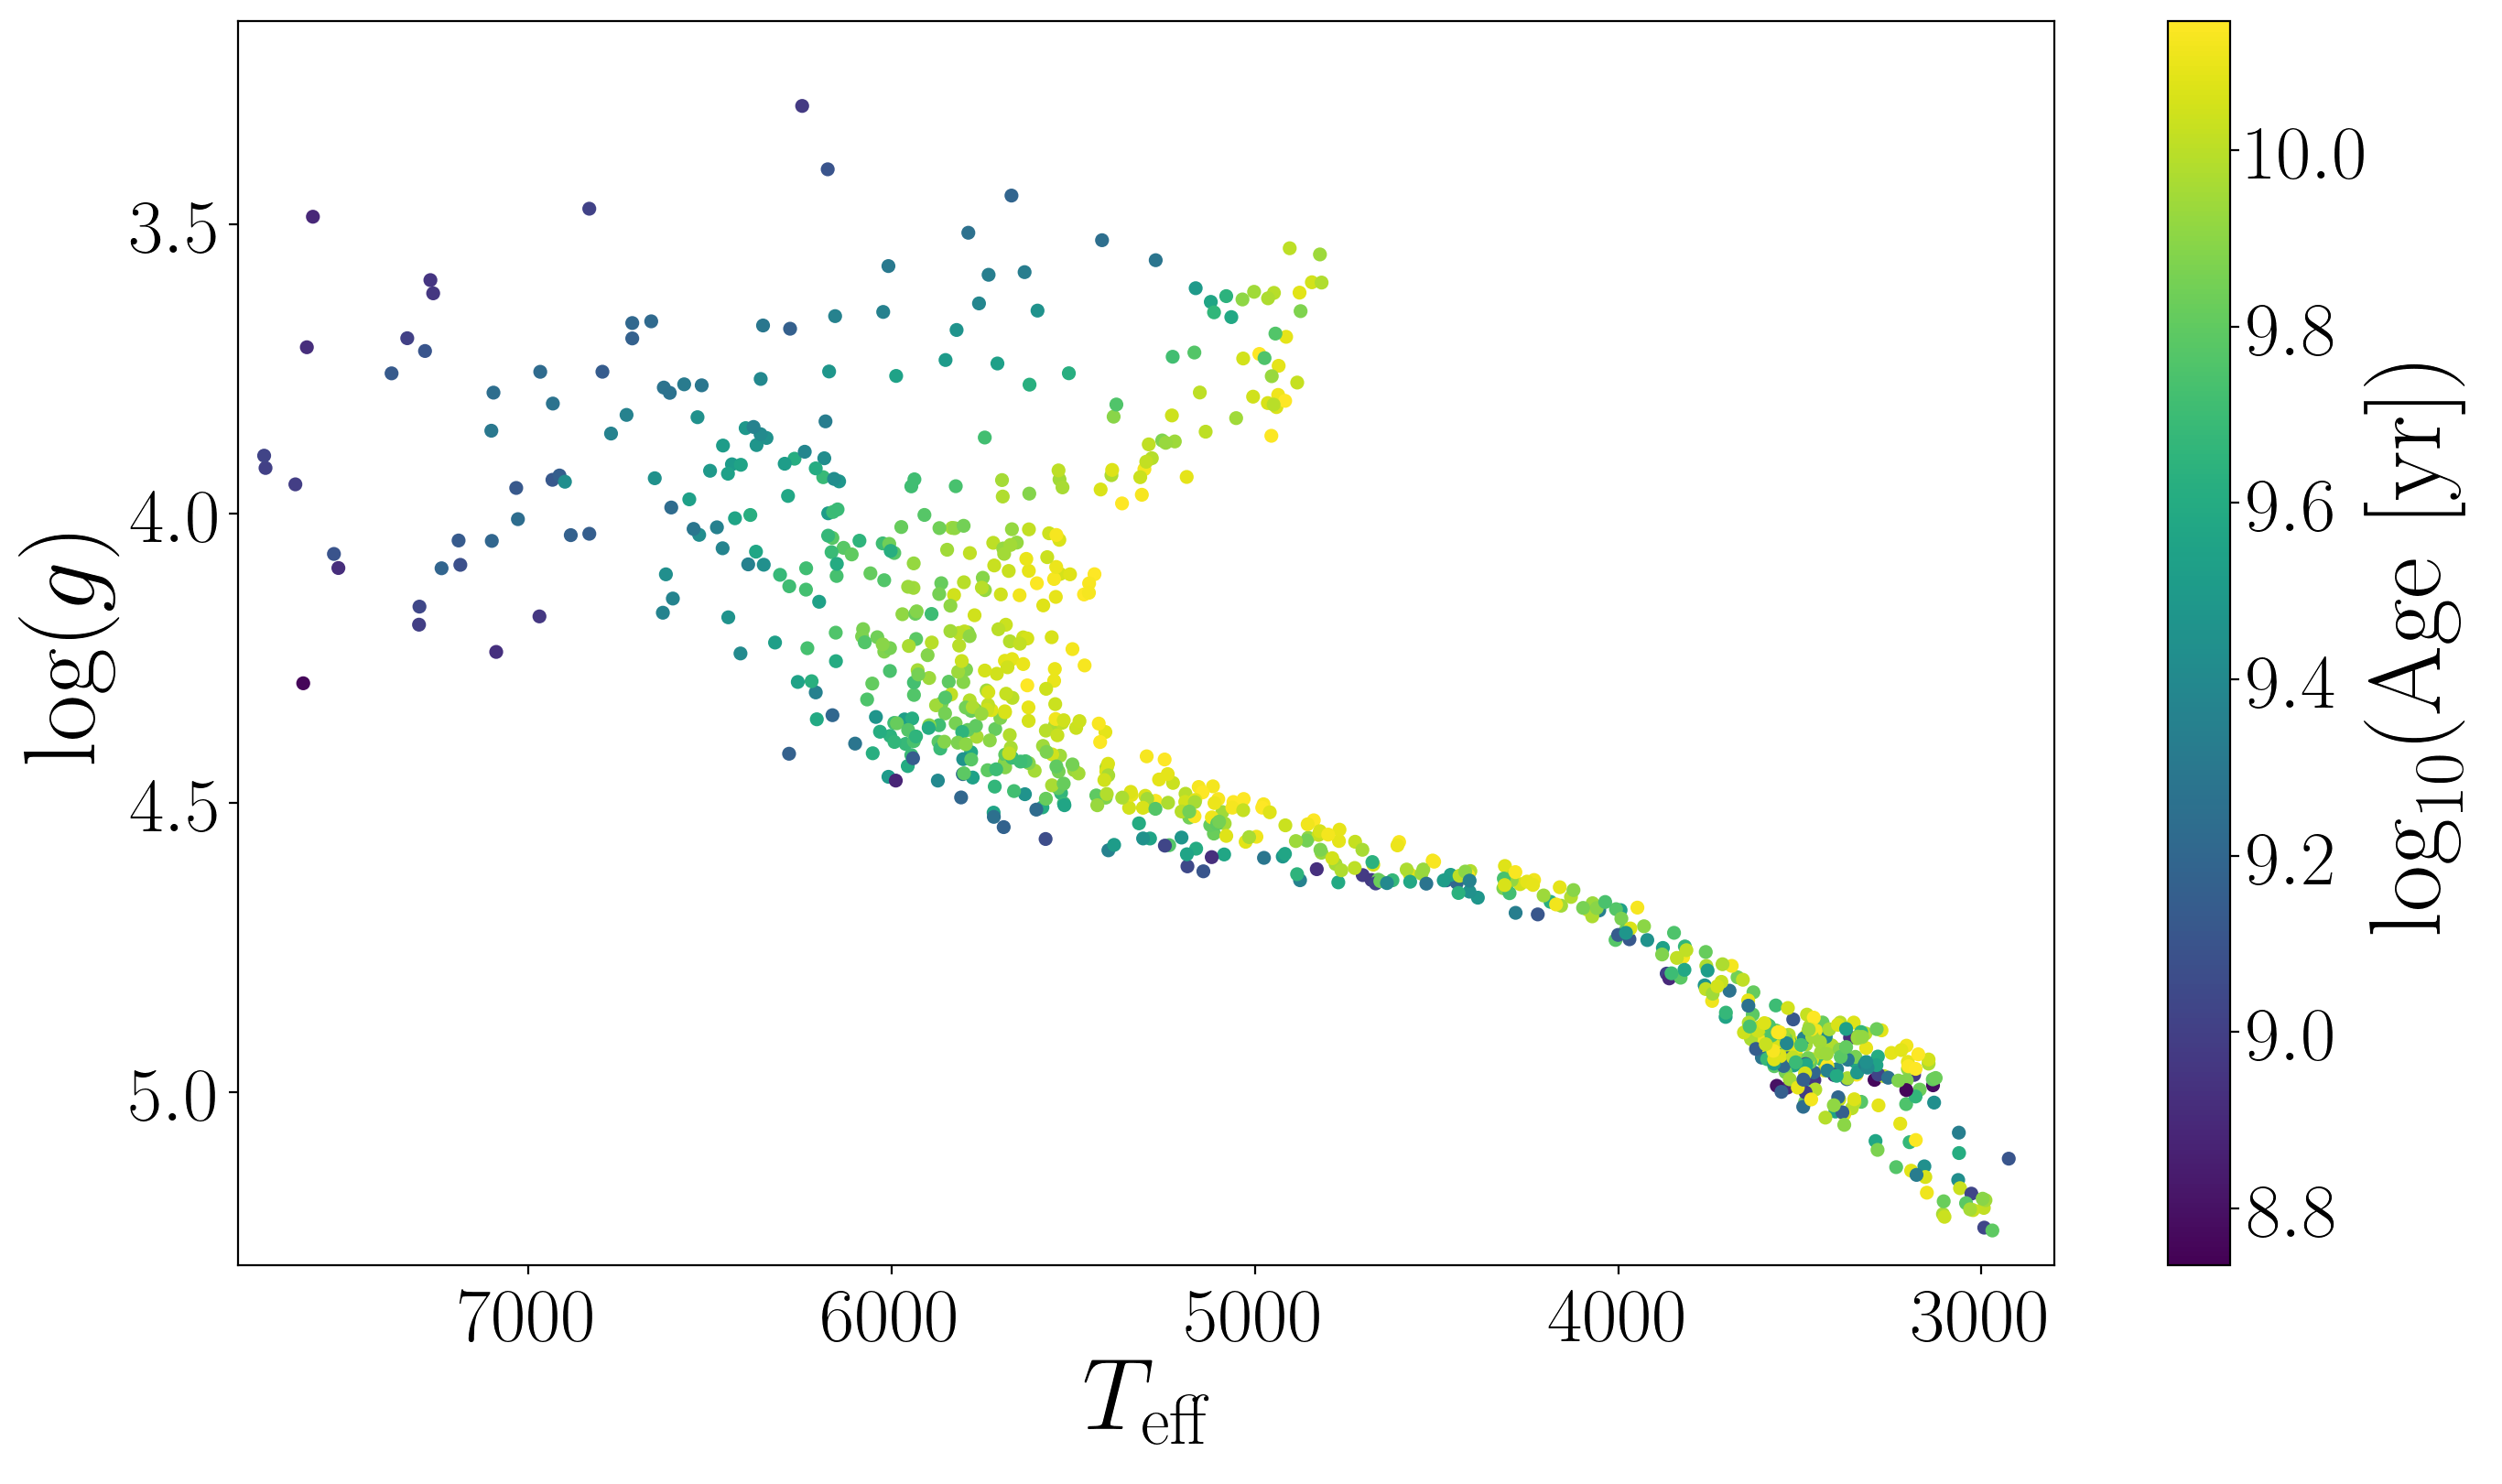

In [45]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff, df.logg, c=df.age, s=20)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")
# plt.savefig("../simulated_CMD.pdf")

Plot a corner plot for the first star.

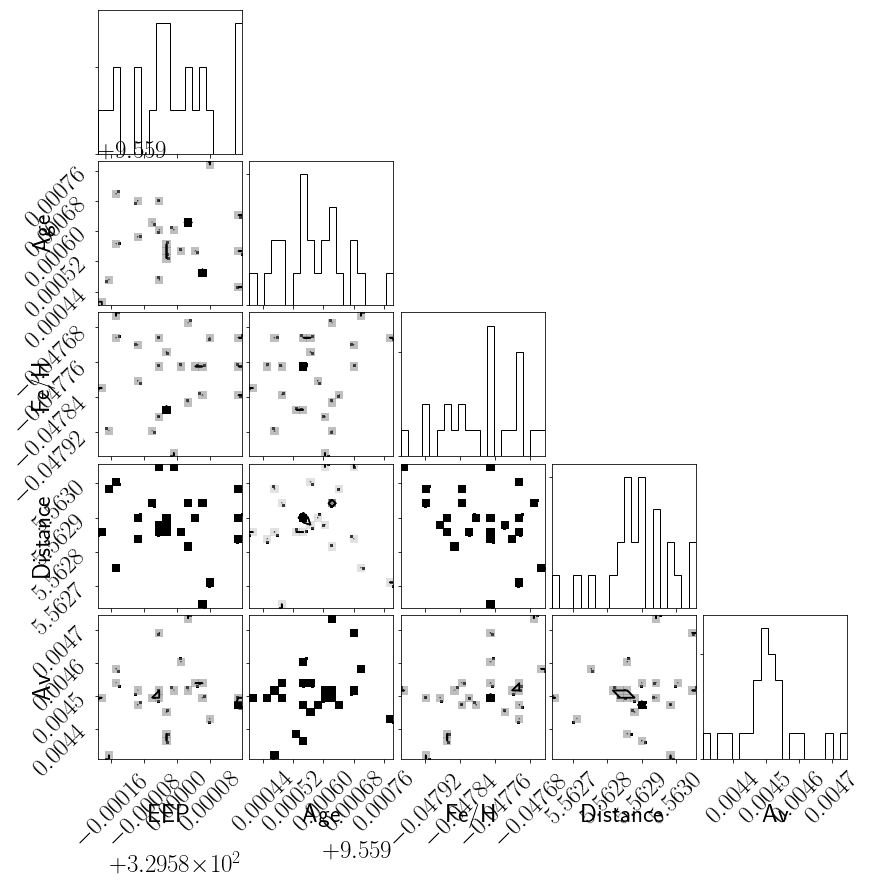

In [74]:
i = 0
# fname = "simulation_results/{}_stardate_p_noise.h5".format(str(i).zfill(4))
# pr = pd.read_csv("data/praesepe.csv")
# fname = "praesepe_results/{}_iso.h5".format(str(pr.EPIC.values[i]).zfill(9))
# fname = "praesepe_results/211707676_praesepe_gyro.h5"
# # fname = "praesepe_results/211999343_praesepe_angus.h5"
# fname = "211707676_praesepe_angus.h5"
# fname = "simulation_results/0000_stardate_noise.h5"
# fname = "praesepe_results/211707676_praesepe_angus.h5"
fname = "../../stardate/tests/star_test.h5"
fname = "simulation_results/0015_stardate_p_noise.h5"

reader = emcee.backends.HDFBackend(fname, read_only=True)
samples = reader.get_chain()
lnprobs = reader.get_log_prob()
nsteps, nwalkers, ndim = np.shape(samples)
augmented = np.zeros((nsteps, nwalkers, ndim+1))
augmented[:, :, :-1] = samples
augmented[:, :, -1] = lnprobs
nsteps, nwalkers, ndim = np.shape(samples)
    
burnin = 0
samps = np.reshape(samples[burnin:, :, :], (nwalkers*(nsteps - burnin), ndim))
# tr = [df.eep.values[i], df.age.values[i], df.feh.values[i], np.log(1./(df.parallax[i]*1e-3)),
#       df.Av.values[i], None]
# tr = [None, np.log10(650*1e6), 0., np.log(177), .035, None]
# tr = [355, np.log10(4.56*1e9), 0., np.log(1000), 0., None]

labels = ["EEP", "Age", "Fe/H", "Distance", "Av"]#, "lnprob"]
corner.corner(samps, truths=tr, labels=labels);

4.087787845261875
[ 3.45114630e+02  9.61148835e+00  1.73564581e-02  6.93791142e+00
  4.98270819e-02 -1.28422043e+01]
(-308.21965218842325, -18.41868249701437)
(-243.79041004765517, -17.38251728543173)


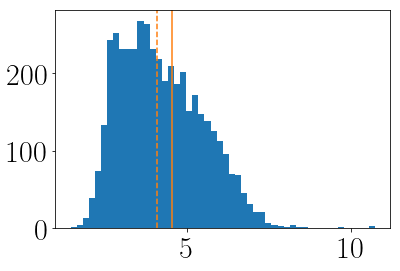

In [41]:
plt.hist((10**samps[100:, 1])*1e-9, 50);
plt.axvline(4.56, color="C1")

med = (10**np.median(samps[:, 1]))*1e-9
print(med)
plt.axvline(med, color="C1", ls="--")

# plt.hist(samps[:, 1], 50);
# plt.axvline(np.log10(4.56*1e9), color="C1")

from isochrones import StarModel, get_ichrone
bands = ["B", "V", "J", "H", "K", "BP", "RP"]
mist = get_ichrone("mist", bands=bands)


from stardate.lhf import lnprob

iso_params = {"teff": (5777, 10),
              "logg": (4.44, .05),
              "feh": (0., .001),
              "parallax": (1., .01),  # milliarcseconds
              "B": (15.48, 0.02)}

# Set up the StarModel isochrones object.
mod = StarModel(mist, **iso_params)
# the lnprob arguments]
args = [mod, 26., 1., False, False, True, "praesepe"]

sun = [355, np.log10(4.56*1e9), 0., np.log(1000), 0.]
sun2 = np.median(samps, axis=0)
print(sun2)

print(lnprob(sun, *args))
print(lnprob(sun2, *args))

### And plot the trace.

[354.8514453814746, 9.629092406309297, -0.01724173710415504, 7.006410483074223, 0.08750815074540705]


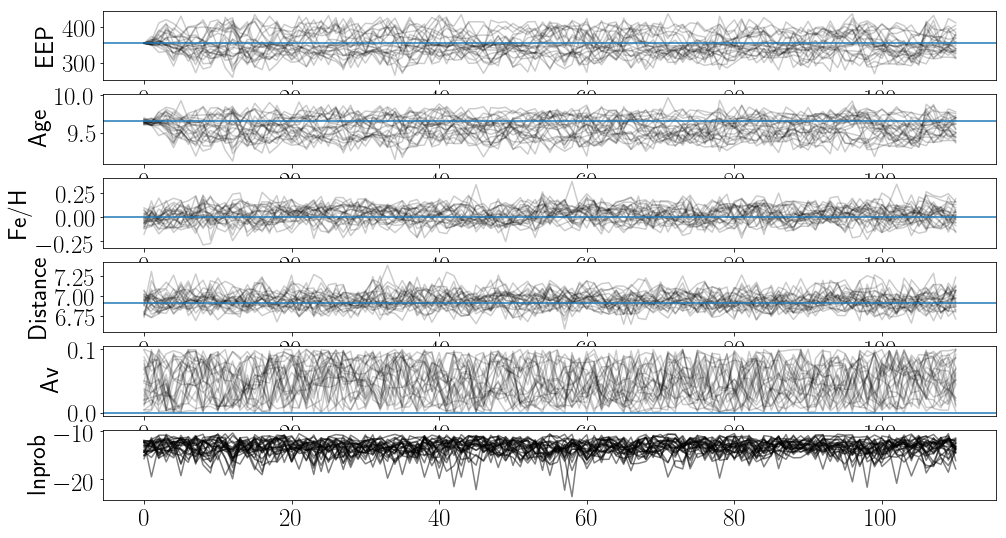

In [224]:
nsteps, nwalkers, ndim = np.shape(samples)
flat = np.reshape(samples, (nsteps*nwalkers, ndim))
plt.figure(figsize=(16, 9))
inits = []
for j in range(5):
    plt.subplot(6, 1, j+1)
    inits.append(samples[0, 0, j])
    plt.plot(samples[:, :, j], color="k", alpha=.2)
    plt.ylabel(labels[j])
    if tr[j] is not None:
        plt.axhline(tr[j])
plt.subplot(6, 1, 6)
plt.plot(lnprobs, "k", alpha=.5)
plt.ylabel(labels[5])
print(inits)

Now plot all the results.

In [46]:
def percentiles_from_samps(samps):
    med = np.median(samps)
    std = np.std(samps)
    upper = np.percentile(samps, 84)
    lower = np.percentile(samps, 16)
    errp = upper - med
    errm = med -lower
    return med, errp, errm, std


def read_files(name, ids, dirname=".", burnin=100):
    meds, age_samps, errp, errm, std, inds = [], [], [], [], [], []
    
    for i, ID in enumerate(ids):
        try:
            fname = "{0}/{1}_{2}.h5".format(dirname, str(int(ID)).zfill(4), name)
            reader = emcee.backends.HDFBackend(fname)
            samples = reader.get_chain()
            
            if np.shape(samples)[0] > 10:
                nsteps, nwalkers, ndim = np.shape(samples)
                samps = np.reshape(samples, (nsteps*nwalkers, ndim))
            
                a, ap, am, _std = percentiles_from_samps((10**samps[burnin:, 1])*1e-9)
                age_samps.append((10**samps[burnin:, 1])*1e-9)
                meds.append(a)
                errp.append(ap)
                errm.append(am)
                std.append(_std)
                inds.append(i)
                    
        except:
            pass
    
    return age_samps, np.array(meds), np.array(errp), np.array(errm), np.array(std), np.array(inds)

# age_samps, meds, errp, errm, std, inds = read_files("stardate_noise", np.arange(1000),
age_samps, meds, errp, errm, std, inds = read_files("stardate_p_noise", np.arange(69),
                                                    dirname="simulation_results")
print(len(inds))

69


Select stars of different types.

In [71]:
def selection(df, inds, model="angus15"):
    
    if model == "angus15":
        hot_cut, cool_cut, giant_cut, ro_cut = .45, 1.35, 440, 1.8
        Ro = (df.prot.values[inds]/convective_overturn_time(df.mass.values[inds]))
        evolved = (df.eep.values[inds] > giant_cut) #* (df.BV.values[inds] > hot_cut)
        hot = (df.BV.values[inds] < hot_cut) * (df.eep.values[inds] < giant_cut)
        hot_evolved = (df.BV.values[inds] < hot_cut) * (df.eep.values[inds] > giant_cut)
        cool = (df.BV.values[inds] > cool_cut) * (df.eep.values[inds] < giant_cut) * (Ro < ro_cut)
        fgk = (df.eep.values[inds] < giant_cut) * (df.BV.values[inds] > hot_cut) * \
            (df.BV.values[inds] < cool_cut) * (Ro < ro_cut)
        rossbied = (Ro > ro_cut) * (df.BV.values[inds] > hot_cut) * (df.BV.values[inds] < cool_cut) \
            * (df.eep.values[inds] < giant_cut)
        
    elif model == "praesepe":
        bprp = df.BP.values[inds] - df.RP.values[inds]
        hot_cut, cool_cut, giant_cut, ro_cut = .56, 2.7, 440, 1.8
        Ro = (df.prot.values[inds]/convective_overturn_time(df.mass.values[inds]))
        evolved = (df.eep.values[inds] > giant_cut)
        hot = (bprp < hot_cut) * (df.eep.values[inds] < giant_cut)
        hot_evolved = (bprp < hot_cut) * (df.eep.values[inds] > giant_cut)
        cool = (bprp > cool_cut) * (df.eep.values[inds] < giant_cut) * (Ro < ro_cut)
        fgk = (df.eep.values[inds] < giant_cut) * (bprp > hot_cut) * (bprp < cool_cut) * (Ro < ro_cut)
        rossbied = (Ro > ro_cut) * (bprp > hot_cut) * (bprp < cool_cut) * (df.eep.values[inds] < giant_cut)
        
        
    return fgk, hot, cool, evolved, rossbied

fgk, hot, cool, evolved, rossbied = selection(df, inds, model="praesepe")
print(inds[cool])

[15 30 55]


Now load isochrone-only posteriors.

In [48]:
iage_samps, imeds, ierrp, ierrm, istd, iinds = read_files("isochrones", np.arange(1000),
                                                          dirname="old_lhf")
ifgk, ihot, icool, ievolved, irossbied = selection(df, iinds)

Plot the empirical precision on the HR diagram (use log g to spread out the main sequence better).

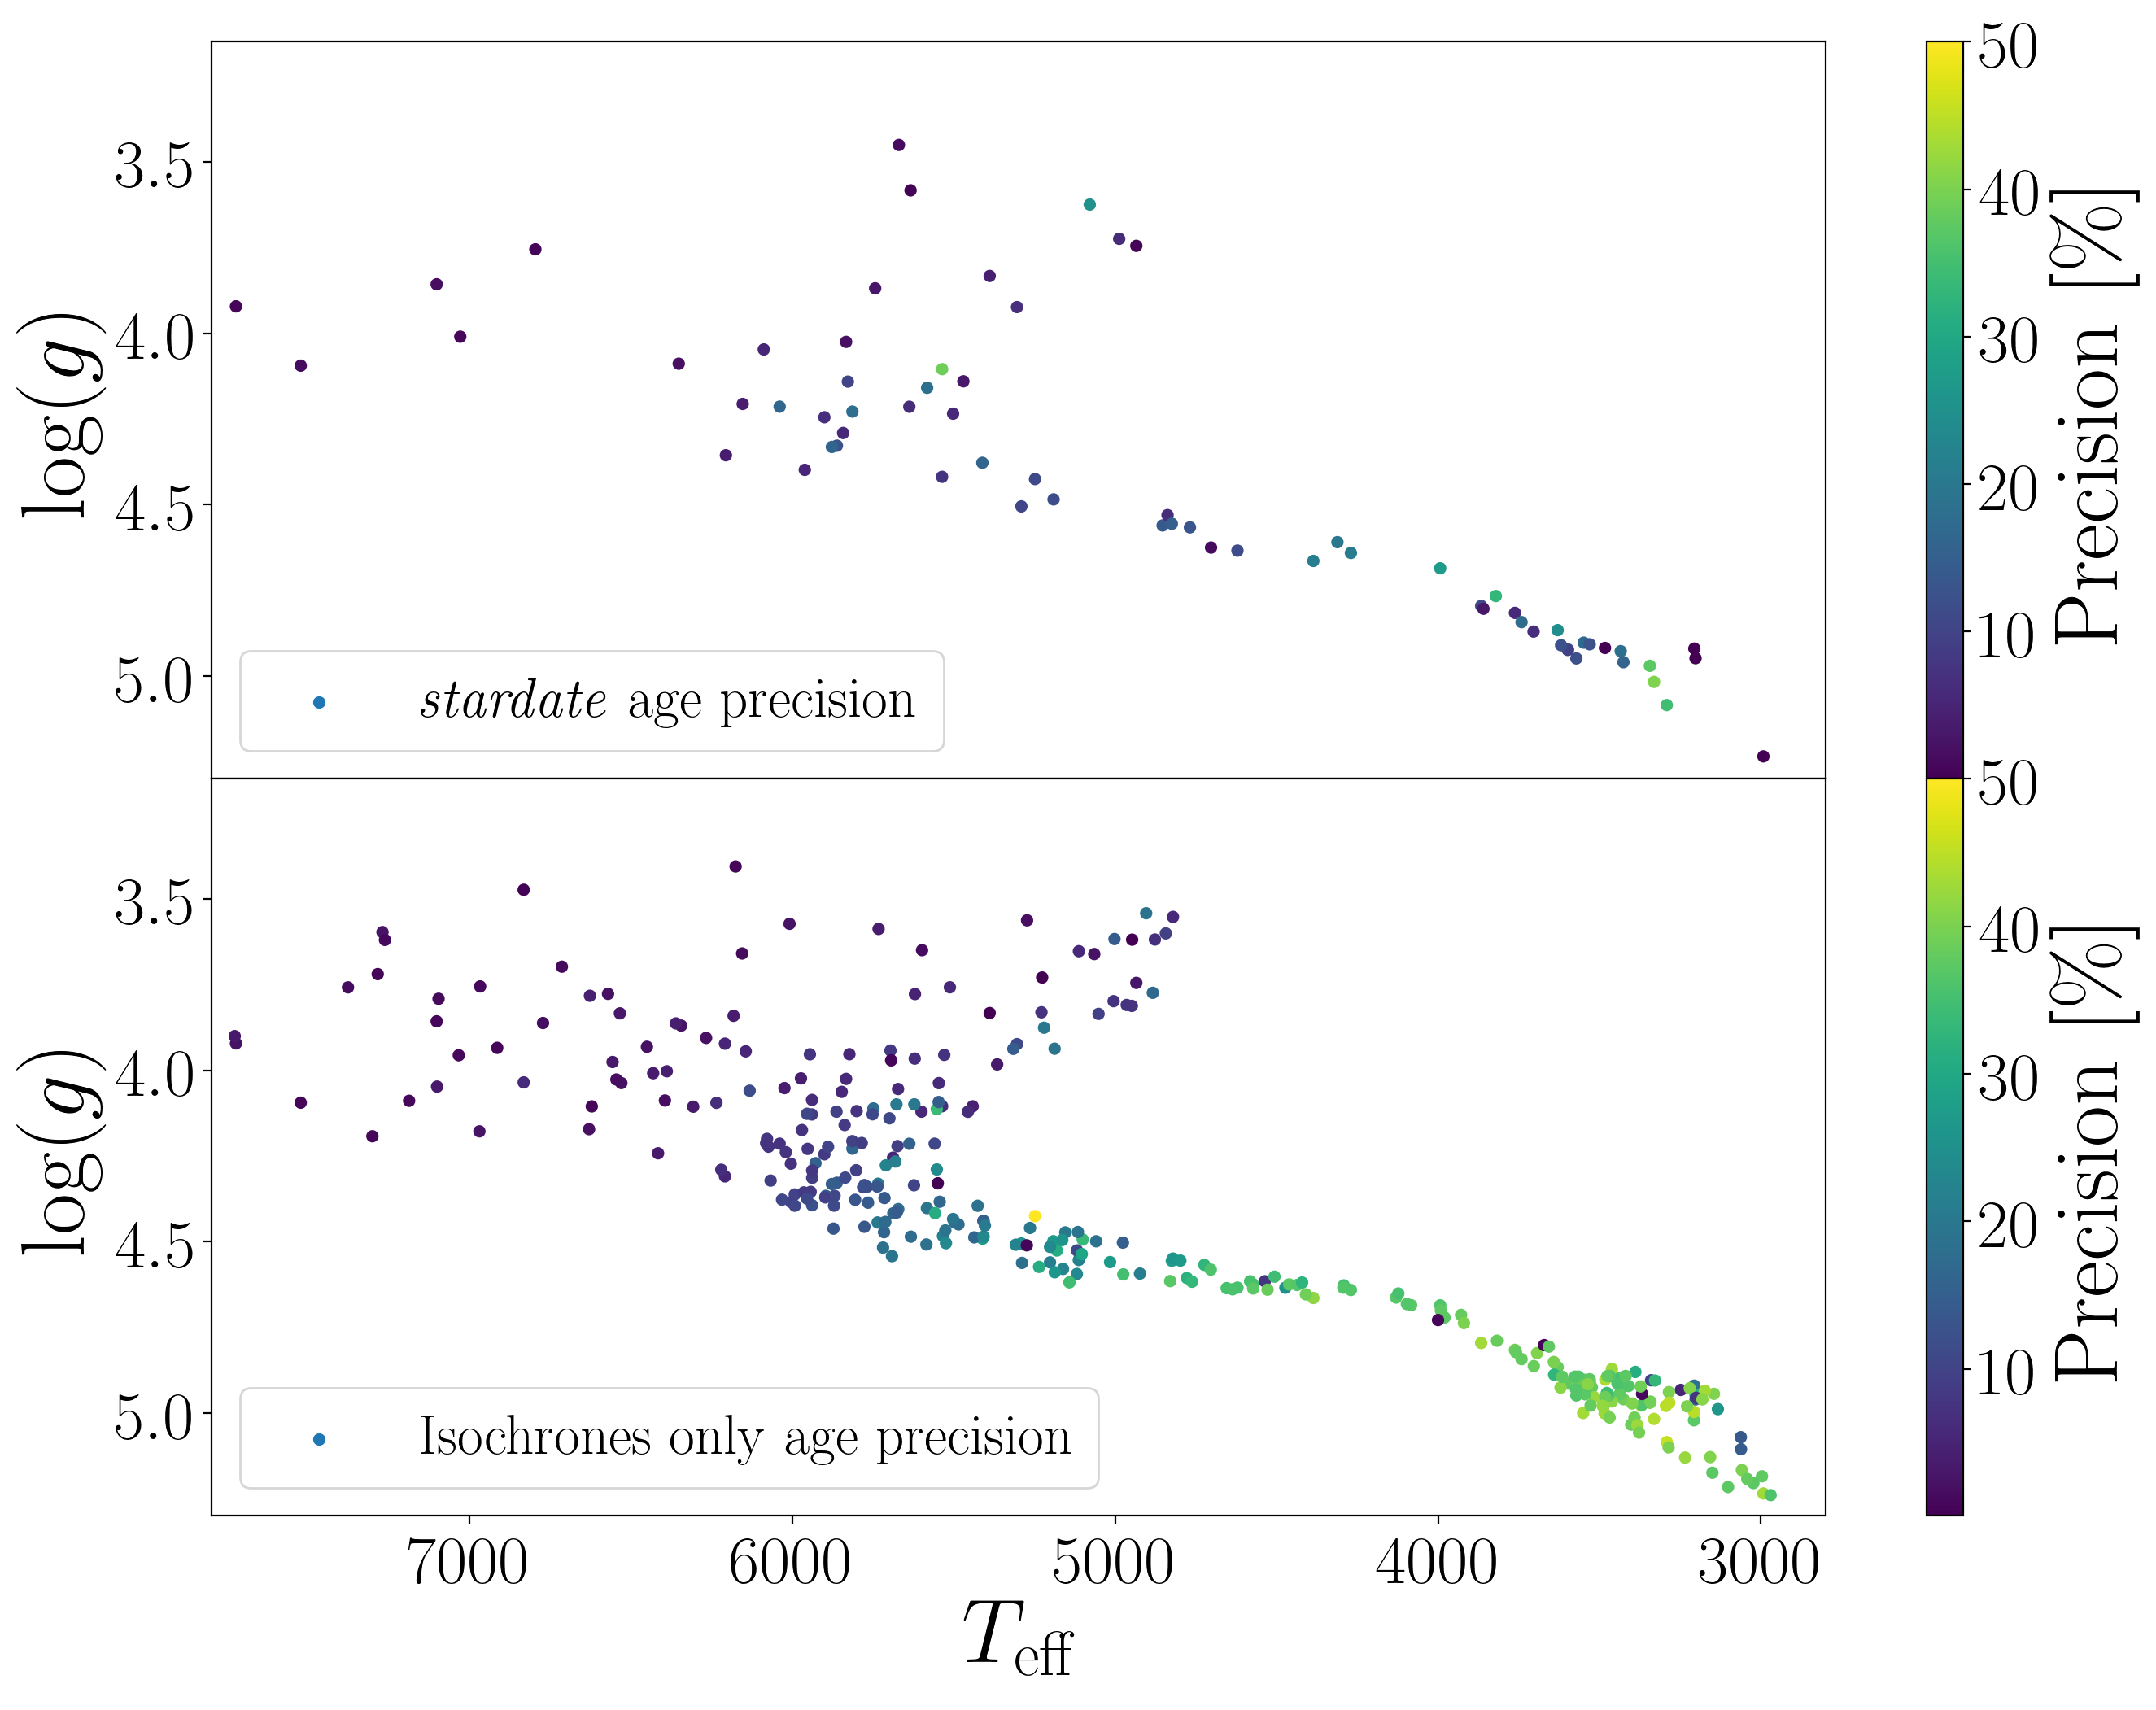

In [49]:
plotpar = {'legend.fontsize': 25}
plt.rcParams.update(plotpar)

plt.figure(figsize=(16, 12), dpi=200)
plt.subplot(2, 1, 1)
plt.scatter(df.teff.values[inds], df.logg.values[inds], label="$\mathrm{{\it stardate}~age~precision}$",
            c=(std/df.age.values[inds])*100, s=20, vmax=50, rasterized=True)
plt.colorbar(label="$\mathrm{Precision~[\%]}$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")
plt.legend(loc="lower left")

plt.subplot(2, 1, 2)
plt.scatter(df.teff.values[iinds], df.logg.values[iinds], label="$\mathrm{Isochrones~only~age~precision}$",
            c=(istd/df.age.values[iinds])*100, s=20, vmax=50, rasterized=True)
plt.colorbar(label="$\mathrm{Precision~[\%]}$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")
plt.subplots_adjust(hspace=0)
plt.legend(loc="lower left")

plt.savefig("../precision_plot.pdf")

[21 26 33 51 56 62]


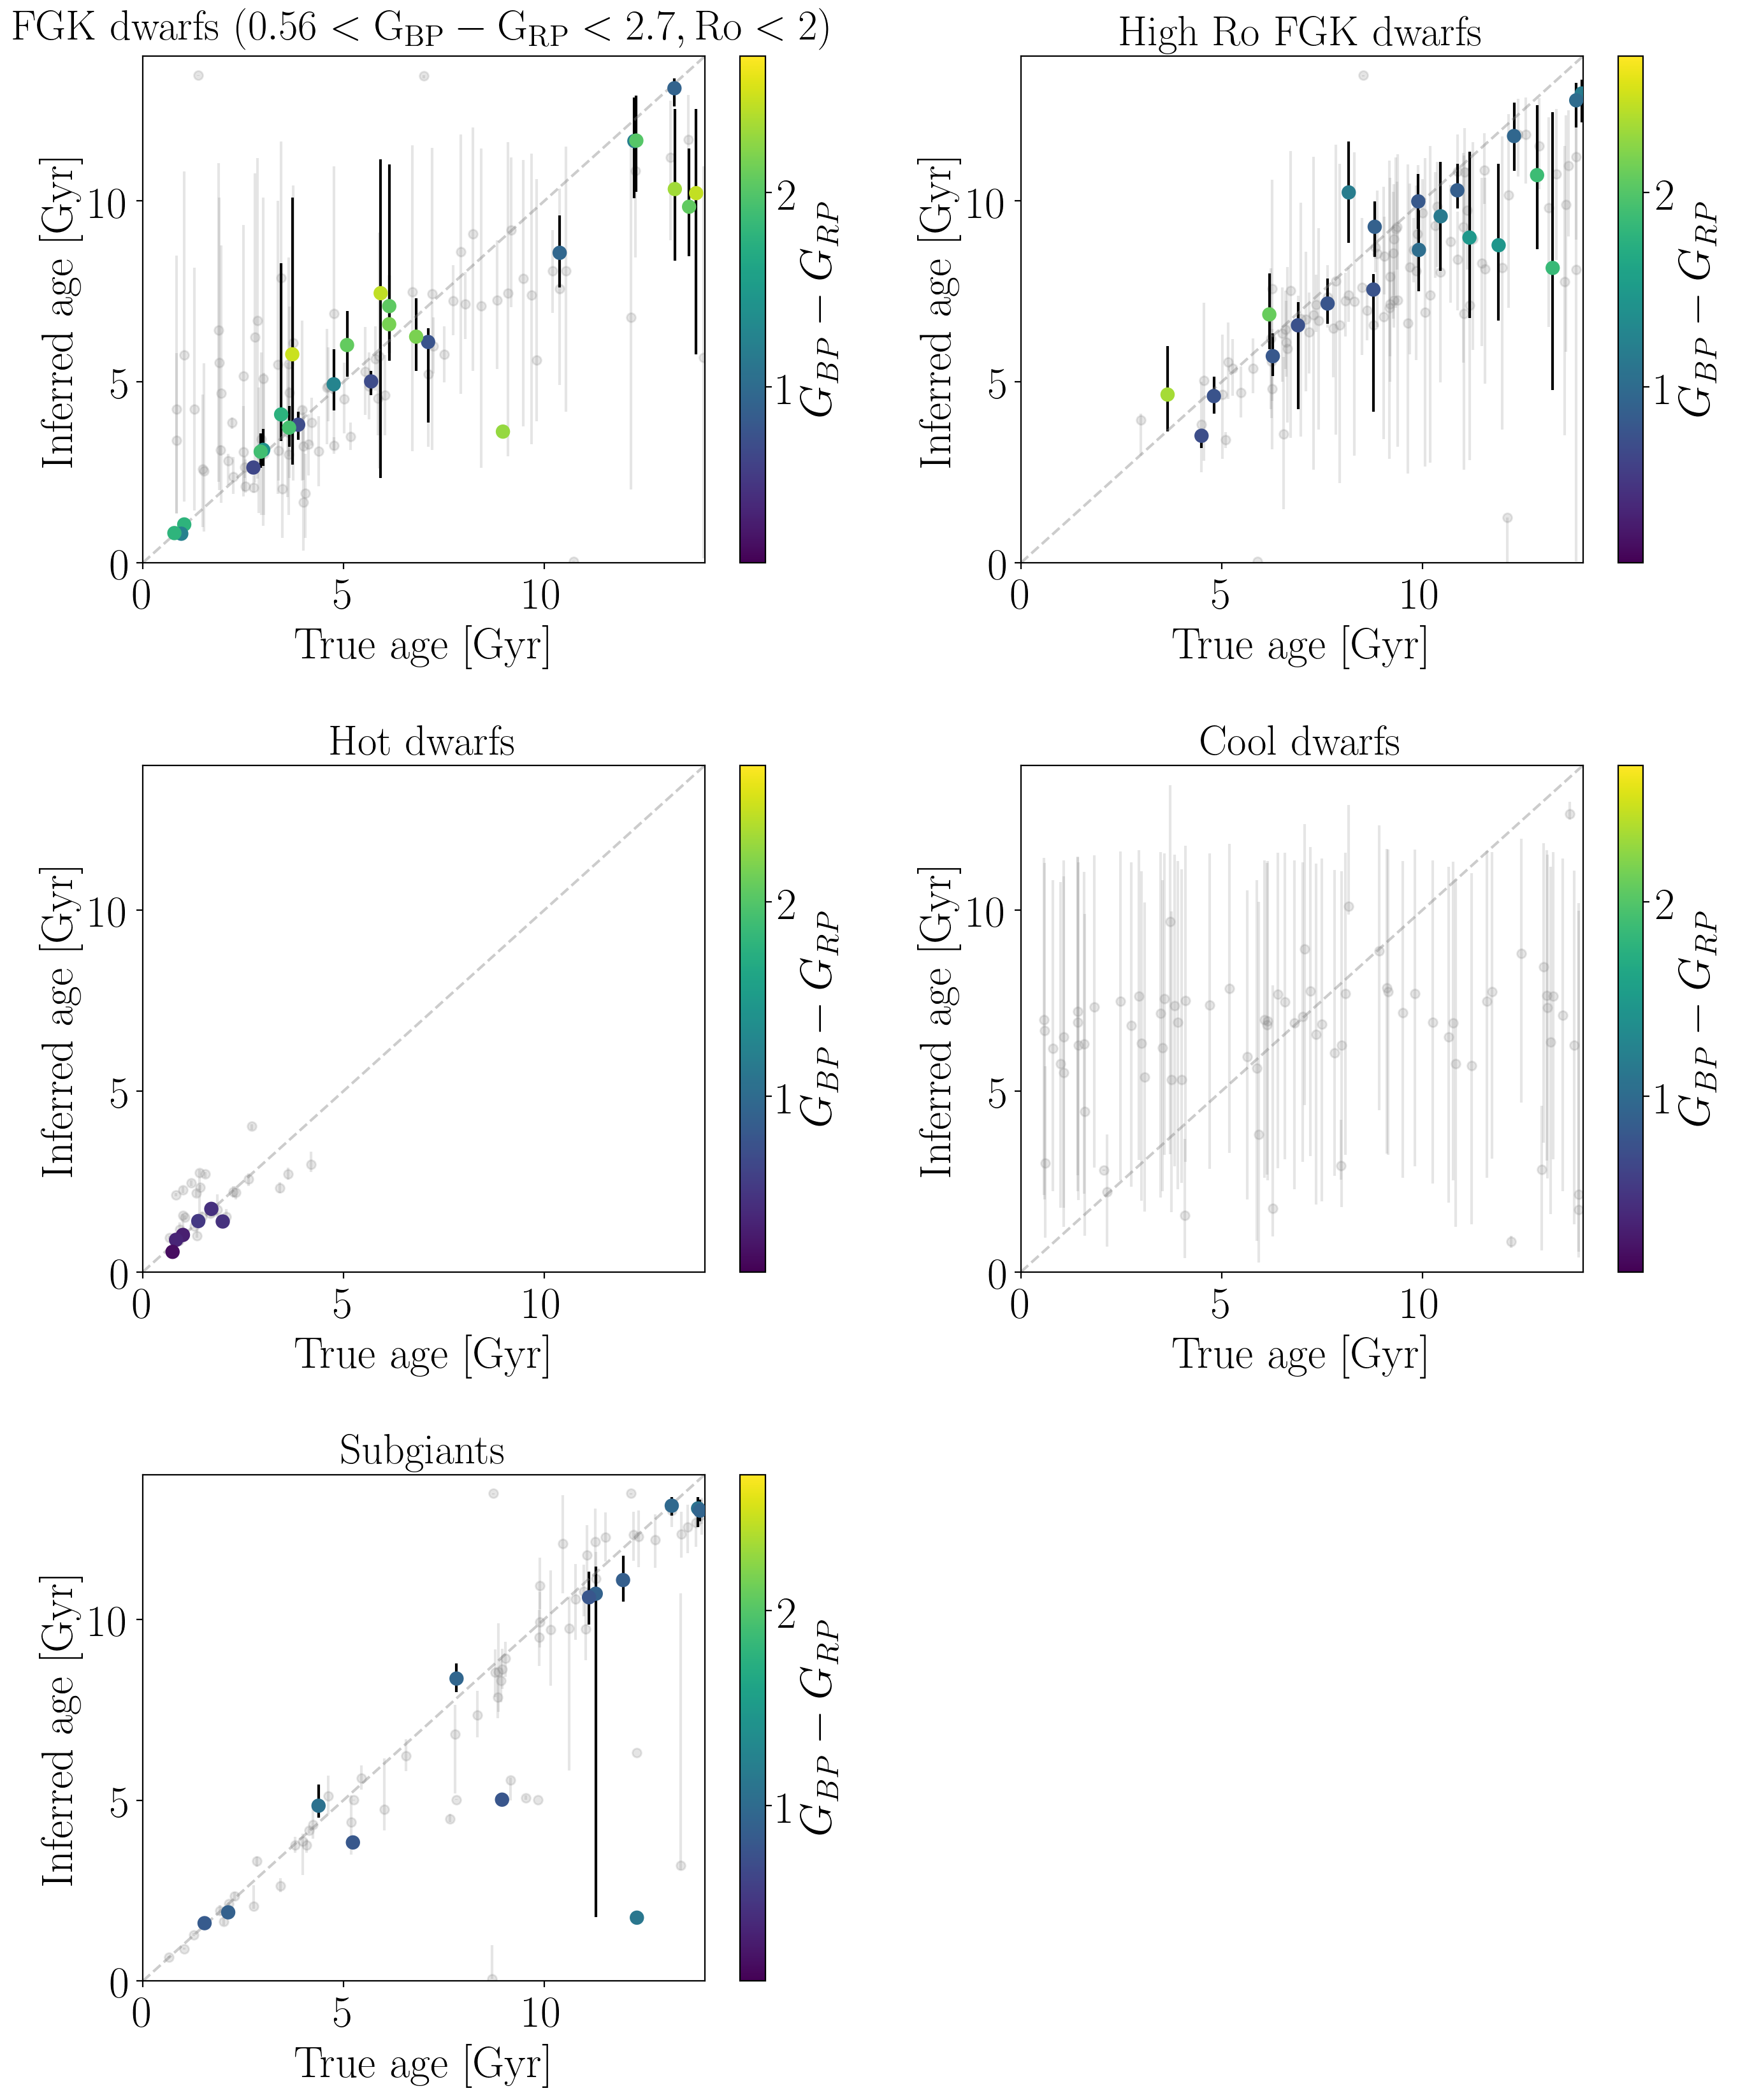

In [82]:
plotpar = {'axes.labelsize': 25,
           'font.size': 20,
           'legend.fontsize': 12,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

plt.figure(figsize=(16, 20), dpi=200)
plt.subplot(3, 2, 1)

# plt.errorbar(true_age_gyr[inds][fgk], meds[fgk], yerr=[errm[fgk], errp[fgk]], fmt=".",
#              ms=10, zorder=2, label="$\mathrm{{stardate}}$", rasterized=True, color="tab:orange")
plt.errorbar(true_age_gyr[inds][fgk], meds[fgk], yerr=[errm[fgk], errp[fgk]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{{stardate}}$", rasterized=True, color="k")
plt.scatter(true_age_gyr[inds][fgk], meds[fgk], c=df.BP[inds][fgk] - df.RP[inds][fgk],
             s=50, zorder=3, vmin=min(df.BP-df.RP), vmax=2.7)
plt.colorbar(label="$G_{BP} - G_{RP}$")

plt.errorbar(true_age_gyr[iinds][ifgk], imeds[ifgk], yerr=[ierrm[ifgk], ierrp[ifgk]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend(loc="lower right")
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("$\mathrm{FGK~dwarfs~(0.56 < G_{BP}-G_{RP} < 2.7, Ro < 2)}$")

plt.subplot(3, 2, 2)
# plt.errorbar(true_age_gyr[inds][rossbied], meds[rossbied], yerr=[errm[rossbied], errp[rossbied]], fmt=".", 
#              color="tab:purple", ms=10, zorder=2, label="$\mathrm{{stardate}}$", rasterized=True)
plt.errorbar(true_age_gyr[inds][rossbied], meds[rossbied], yerr=[errm[rossbied], errp[rossbied]], fmt=".", 
             color="k", ms=10, zorder=2, label="$\mathrm{{stardate}}$", rasterized=True)
plt.scatter(true_age_gyr[inds][rossbied], meds[rossbied], c=df.BP[inds][rossbied] - df.RP[inds][rossbied],
             s=50, zorder=3, vmin=min(df.BP-df.RP), vmax=2.7)
plt.errorbar(true_age_gyr[iinds][irossbied], imeds[irossbied], yerr=[ierrm[irossbied], ierrp[irossbied]], 
             fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend(loc="lower right")
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.colorbar(label="$G_{BP} - G_{RP}$")
plt.title("$\mathrm{High~Ro~FGK~dwarfs}$")

plt.subplot(3, 2, 3)
# plt.errorbar(true_age_gyr[inds][hot], meds[hot], yerr=[errm[hot], errp[hot]], fmt=".", 
#              color="tab:cyan", ms=10, zorder=2, label="$\mathrm{{stardate}}$", rasterized=True)
plt.errorbar(true_age_gyr[inds][hot], meds[hot], yerr=[errm[hot], errp[hot]], fmt=".", 
             color="k", ms=10, zorder=2, label="$\mathrm{{stardate}}$", rasterized=True)
plt.scatter(true_age_gyr[inds][hot], meds[hot], c=df.BP[inds][hot] - df.RP[inds][hot],
             s=50, zorder=3, vmin=min(df.BP-df.RP), vmax=2.7)
plt.errorbar(true_age_gyr[iinds][ihot], imeds[ihot], yerr=[ierrm[ihot], ierrp[ihot]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend(loc="lower right")
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.colorbar(label="$G_{BP} - G_{RP}$")
plt.title("$\mathrm{Hot~dwarfs}$")

plt.subplot(3, 2, 4)
m = (3.627 < meds[cool]) * (meds[cool] > 3.628)
# plt.errorbar(true_age_gyr[inds][cool], meds[cool], yerr=[errm[cool], errp[cool]], fmt=".",
#              color="tab:red", ms=10, zorder=2, label="$\mathrm{{stardate}}$", rasterized=True)
plt.errorbar(true_age_gyr[inds][cool][m], meds[cool][m], yerr=[errm[cool][m], errp[cool][m]], fmt=".",
             color="k", ms=10, zorder=2, label="$\mathrm{{stardate}}$", rasterized=True)
plt.scatter(true_age_gyr[inds][cool][m], meds[cool][m], c=df.BP[inds][cool][m] - df.RP[inds][cool][m],
             s=50, zorder=3, vmin=min(df.BP-df.RP), vmax=2.7)
plt.errorbar(true_age_gyr[iinds][icool], imeds[icool], yerr=[ierrm[icool], ierrp[icool]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend(loc="lower right")
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14) 
plt.colorbar(label="$G_{BP} - G_{RP}$")
plt.title("$\mathrm{Cool~dwarfs}$")

plt.subplot(3, 2, 5)
# plt.errorbar(true_age_gyr[inds][evolved], meds[evolved], yerr=[errm[evolved], errp[evolved]], fmt=".",
#              ms=10, zorder=2, label="$\mathrm{{stardate}}$", rasterized=True, color="tab:green")
plt.errorbar(true_age_gyr[inds][evolved], meds[evolved], yerr=[errm[evolved], errp[evolved]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{{stardate}}$", rasterized=True, color="k")
plt.scatter(true_age_gyr[inds][evolved], meds[evolved], c=df.BP[inds][evolved] - df.RP[inds][evolved],
             s=50, zorder=3, vmin=min(df.BP-df.RP), vmax=2.7)
plt.errorbar(true_age_gyr[iinds][ievolved], imeds[ievolved], yerr=[ierrm[ievolved], ierrp[ievolved]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend(loc="lower right")
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.colorbar(label="$G_{BP} - G_{RP}$")
plt.title("$\mathrm{Subgiants}$")

plt.subplots_adjust(wspace=.25, hspace=.4)
plt.savefig("../simulation_results.pdf")
plt.savefig("simulation_results")

print(inds[hot])

Calculate precision for stardate.

In [124]:
def precision(stds, meds):
    return np.median(stds/meds)*100

def accuracy(true, meds):
    return np.median(abs(meds - true))*1e3

def rel_acc(true, meds):
    return np.median((abs(meds - true)/meds)*100)

print("median FGK age precision = {:.2f} %".format(precision(std[fgk], meds[fgk])))
print("median FGK absolute age error = {:.2f} Myr".format(accuracy(true_age_gyr[inds][fgk], meds[fgk])))
print("median FGK relative age error = {:.2f} %".format(rel_acc(true_age_gyr[inds][fgk], meds[fgk])))

print("\nmedian high Ro age precision = {:.2f} %".format(precision(std[rossbied], meds[rossbied])))
print("median high Ro absolute age error = {:.2f} Myr".format(accuracy(true_age_gyr[inds][rossbied], 
                                                                          meds[rossbied])))
print("median high Ro relative age error = {:.2f} %".format(rel_acc(true_age_gyr[inds][rossbied], 
                                                                          meds[rossbied])))

print("\nmedian hot age precision = {:.2f} %".format(precision(std[hot], meds[hot])))
print("median hot absolute age error = {:.2f} Myr".format(accuracy(true_age_gyr[inds][hot], meds[hot])))
print("median hot relative age error = {:.2f} %".format(rel_acc(true_age_gyr[inds][hot], meds[hot])))

print("\nmedian cool age precision = {:.2f} %".format(precision(std[cool], meds[cool])))
print("median cool absolute age error = {:.2f} Myr".format(accuracy(true_age_gyr[inds][cool], meds[cool])))
print("median cool relative age error = {:.2f} %".format(rel_acc(true_age_gyr[inds][cool], meds[cool])))

print("\nmedian subgiant age precision = {:.2f} %".format(precision(std[evolved], meds[evolved])))
print("median subgiant absolute age error = {:.2f} Myr".format(accuracy(true_age_gyr[inds][evolved], 
                                                                           meds[evolved])))
print("median subgiant relative age error = {:.2f} %".format(rel_acc(true_age_gyr[inds][evolved], 
                                                                           meds[evolved])))

print("\ntotal median age precision = {0}%".format(precision(std, meds)))
print("total median age error = {0}%".format(accuracy(true_age_gyr[inds], meds)))
print("total median age relative error = {0}%".format(rel_acc(true_age_gyr[inds], meds)))

median FGK age precision = 4.39 %
median FGK absolute age error = 98.03 Myr
median FGK relative age error = 2.95 %

median high Ro age precision = 9.40 %
median high Ro absolute age error = 462.83 Myr
median high Ro relative age error = 5.03 %

median hot age precision = 8.43 %
median hot absolute age error = 94.36 Myr
median hot relative age error = 9.81 %

median cool age precision = 19.31 %
median cool absolute age error = 1551.81 Myr
median cool relative age error = 20.46 %

median subgiant age precision = 7.70 %
median subgiant absolute age error = 475.57 Myr
median subgiant relative age error = 6.92 %

total median age precision = 9.181207293549352%
total median age error = 480.5217059733615%
total median age relative error = 6.903751996376332%


Calculate precision for isochrone fitting.

In [24]:
print("median FGK age precision = {:.2f} %".format(precision(istd[ifgk], imeds[ifgk])))
print("median FGK absolute age accuracy = {:.2f} Myr".format(accuracy(true_age_gyr[iinds][ifgk], imeds[ifgk])))
print("median FGK relative age accuracy = {:.2f} Myr".format(rel_acc(true_age_gyr[iinds][ifgk], imeds[ifgk])))

print("\nmedian high Ro age precision = {:.2f} %".format(precision(istd[irossbied], imeds[irossbied])))
print("median high Ro absolute age accuracy = {:.2f} Myr".format(accuracy(true_age_gyr[iinds][irossbied], 
                                                                          imeds[irossbied])))
print("median high Ro relative age accuracy = {:.2f} %".format(rel_acc(true_age_gyr[iinds][irossbied], 
                                                                          imeds[irossbied])))

print("\nmedian hot age precision = {:.2f} %".format(precision(istd[ihot], imeds[ihot])))
print("median hot absolute age accuracy = {:.2f} Myr".format(accuracy(true_age_gyr[iinds][ihot], imeds[ihot])))
print("median hot relative age accuracy = {:.2f} %".format(rel_acc(true_age_gyr[iinds][ihot], imeds[ihot])))

print("\nmedian cool age precision = {:.2f} %".format(precision(istd[icool], imeds[icool])))
print("median cool absolute age accuracy = {:.2f} Myr".format(accuracy(true_age_gyr[iinds][icool], imeds[icool])))
print("median cool relative age accuracy = {:.2f} %".format(rel_acc(true_age_gyr[iinds][icool], imeds[icool])))

print("\nmedian subgiant age precision = {:.2f} %".format(precision(istd[ievolved], imeds[ievolved])))
print("median subgiant absolute age accuracy = {:.2f} Myr".format(accuracy(true_age_gyr[iinds][ievolved], 
                                                                           imeds[ievolved])))
print("median subgiant relative age accuracy = {:.2f} %".format(rel_acc(true_age_gyr[iinds][ievolved], 
                                                                           imeds[ievolved])))

print("\ntotal median age precision = {0}%".format(precision(istd, imeds)))
print("total median age error = {0}%".format(accuracy(true_age_gyr[iinds], imeds)))
print("total median age relative error = {0}%".format(rel_acc(true_age_gyr[iinds], imeds)))

median FGK age precision = 49.19 %
median FGK absolute age accuracy = 1311.87 Myr
median FGK relative age accuracy = 30.49 Myr

median high Ro age precision = 21.89 %
median high Ro absolute age accuracy = 1296.81 Myr
median high Ro relative age accuracy = 16.22 %

median hot age precision = 9.48 %
median hot absolute age accuracy = 510.40 Myr
median hot relative age accuracy = 33.16 %

median cool age precision = 55.13 %
median cool absolute age accuracy = 3939.93 Myr
median cool relative age accuracy = 55.80 %

median subgiant age precision = 8.06 %
median subgiant absolute age accuracy = 581.83 Myr
median subgiant relative age accuracy = 7.50 %

total median age precision = 28.380660165097854%
total median age error = 1285.728567975272%
total median age relative error = 23.16070732862349%


Load Praesepe posteriors.

In [25]:
pr = pd.read_csv("data/praesepe.csv")
finite = np.isfinite(pr.bp.values - pr.rp.values) * np.isfinite(pr.G.values)
pr = pr.iloc[finite]

page_samps, pmeds, perrp, perrm, pstds, pinds = read_files("praesepe_stardate", pr.EPIC.values,
                                                           dirname="praesepe_results")
ipage_samps, ipmeds, iperrp, iperrm, ipstds, ipinds = read_files("praesepe_iso", pr.EPIC.values,
                                                           dirname="praesepe_results")

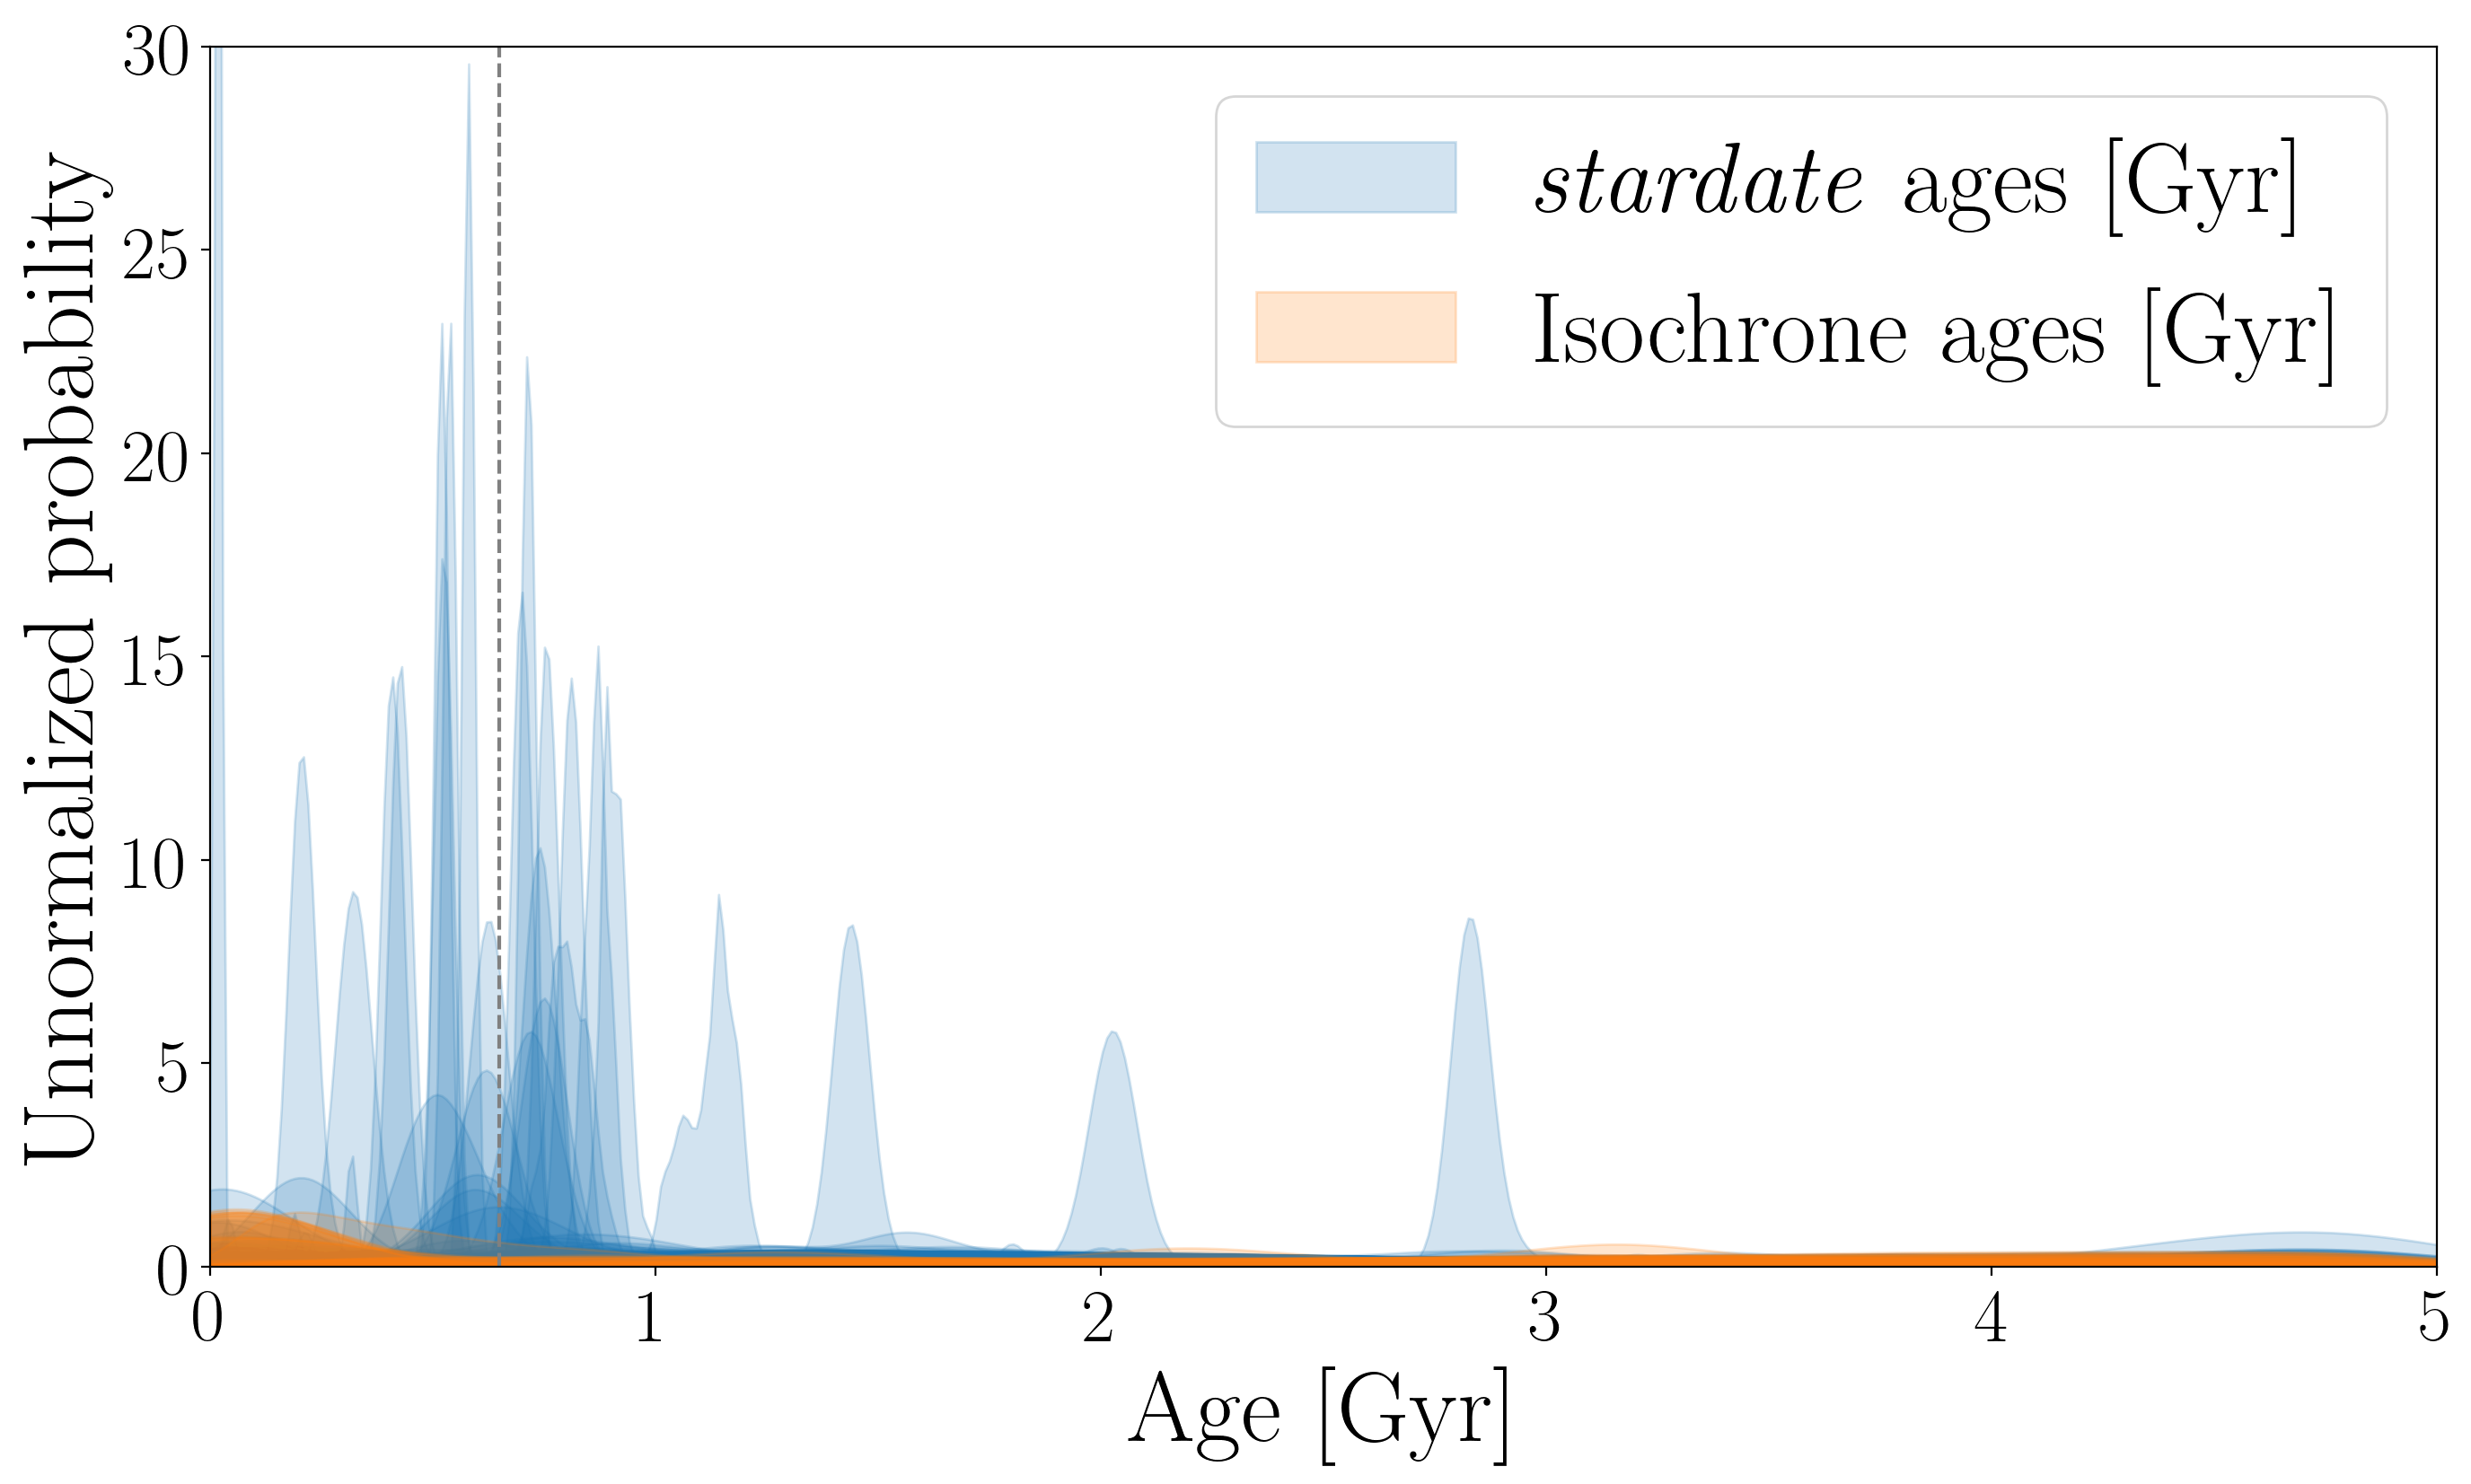

In [26]:
plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 40,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

import scipy.stats as sps

xs = np.linspace(0, 5, 500)

plt.figure(figsize=(16, 9), dpi=200) 

i = 0
mask = np.array(page_samps)[i] < 5
kernel = sps.gaussian_kde(np.array(page_samps)[i][mask])
plt.fill_between(xs, 0, kernel(xs), color="C0", alpha=.2, zorder=1,
                 rasterized=True, label="$\mathrm{{\it stardate}~ages~[Gyr]}$")
# plt.hist(page_samps[i][mask], alpha=.1, color="C0");

for i, samps in enumerate(page_samps):
    mask = np.array(page_samps)[i] < 5
    kernel = sps.gaussian_kde(np.array(page_samps)[i][mask])
    plt.fill_between(xs, 0, kernel(xs), color="C0", alpha=.2, zorder=1,
                     rasterized=True)
#     plt.hist(samps[mask], 50, alpha=.1, color="C0");
    
i = 0
mask = np.array(ipage_samps)[i] < 5
kernel = sps.gaussian_kde(np.array(ipage_samps)[i][mask])
plt.fill_between(xs, 0, kernel(xs), color="C1", alpha=.2, zorder=1,
                 rasterized=True, label="$\mathrm{Isochrone~ages~[Gyr]}$")
# plt.hist(ipage_samps[i][mask], alpha=.1, color="C0");

for i, samps in enumerate(ipage_samps):
    mask = np.array(ipage_samps)[i] < 5
    kernel = sps.gaussian_kde(np.array(ipage_samps)[i][mask])
    plt.fill_between(xs, 0, kernel(xs), color="C1", alpha=.2, zorder=1,
                     rasterized=True)
#     plt.hist(samps[mask], 50, alpha=.1, color="C1");
    
plt.xlim(0, 5)
plt.axvline(.65, color=".5", ls="--")
plt.xlabel("$\mathrm{Age~[Gyr]}$")
plt.ylabel("$\mathrm{Unnormalized~probability}$")
plt.legend()
plt.ylim(0, 30)
plt.savefig("../praesepe_results.pdf")

(15, 2)

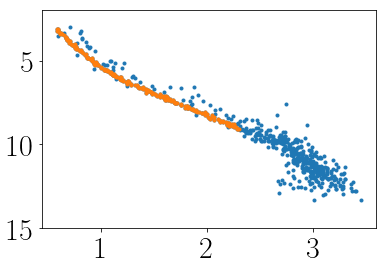

In [521]:
import scipy.optimize as spo

def abs_mag(G, D):
    return - 5*np.log10(D) + 5 + G

def model(p, x):
    return np.polyval(p, x)

def nll(p, x, y, yerr):
    return -sum(-.5*(y - model(p, x))**2/yerr**2)

def clip(x, y, yerr):
    pinit = np.ones(5)
    results = spo.minimize(nll, pinit, args=(x, y, yerr))
    p = results.x

    inds = np.arange(len(x))
    for i in range(10):
        results = spo.minimize(nll, p, args=(x, y, yerr));
        p = results.x
        std = np.std(y - model(p, x))
        m = abs(y - model(p, x)) > 3*std
        x, y, yerr = x[~m], y[~m], yerr[~m]
        inds = inds[~m]
    return x, y, yerr, p, inds

cool = pr.bp.values - pr.rp.values < 2.3

abs_G = abs_mag(pr.G.values, (1./pr.parallax.values)*1e3)
_x, _y, _yerr, _p, _inds = clip(pr.bp.values[cool]-pr.rp.values[cool],
                                abs_G[cool], np.ones(len(abs_G[cool]))*.001)

binary_flag = np.zeros(len(pr.G.values[cool]), dtype=bool)
binary_flag[_inds] = np.ones(len(binary_flag[_inds]), dtype=bool)

plt.plot(pr.bp.values-pr.rp.values, abs_G, ".")
plt.plot(_x, _y, ".")
plt.ylim(15, 2)

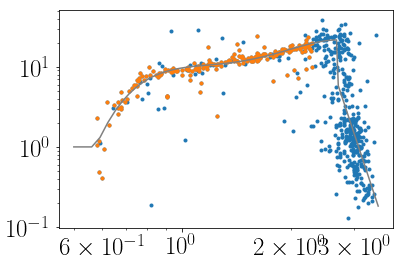

In [408]:
from stardate.lhf import gyro_model_praesepe

plt.plot(bprp.values, pr.prot.values, ".")
plt.plot(bprp.values[fm][m][_inds], pr.prot.values[fm][m][_inds], ".")
xs = np.linspace(.5, 3.5, 100)
ps = np.zeros(len(xs))
for i, x in enumerate(xs):
    ps[i] = gyro_model_praesepe(np.log10(650*1e6), x)
plt.loglog(xs, 10**ps, color=".5")
plt.yscale("log")

In [414]:
page_samps, pmeds, perrp, perrm, pstds, pinds = read_files("praesepe_stardate", pr.EPIC.values,
                                                           dirname="praesepe_results")
print(len(pmeds), "stars")

204 stars


In [415]:
piage_samps, pimeds, pierrp, pierrm, pistds, piinds = read_files("praesepe_iso", pr.EPIC.values,
                                                                 dirname="praesepe_results");
print(len(pimeds), "stars")

23 stars


In [416]:
pgage_samps, pgmeds, pgerrp, pgerrm, pgstds, pginds = read_files("praesepe_gyro", pr.EPIC.values,
                                                                 dirname="praesepe_results")
print(len(pgmeds), "stars")

146 stars


In [418]:
def find_single_measured_inds(pr, measured_inds, meds, errp, errm, std, single_epics):
    epics_measured = pr.iloc[measured_inds]
    epics_measured["age"] = np.array(meds)
    epics_measured["age_errp"] = np.array(errp)
    epics_measured["age_errm"] = np.array(errm)
    epics_measured["age_err"] = np.array(std)
    epics_measured["i"] = np.arange(len(meds))
    final_df = pd.merge(epics_measured, single_epics, on="EPIC", how="inner").drop_duplicates()
    return final_df
    
single_epics = pd.DataFrame(dict({"EPIC": pr.EPIC.values[fm][m][_inds]}))
pdf = find_single_measured_inds(pr, pinds, pmeds, perrp, perrm, pstds, single_epics)
idf = find_single_measured_inds(pr, piinds, pimeds, pierrp, pierrm, pistds, single_epics)
gdf = find_single_measured_inds(pr, pginds, pgmeds, pgerrp, pgerrm, pgstds, single_epics)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

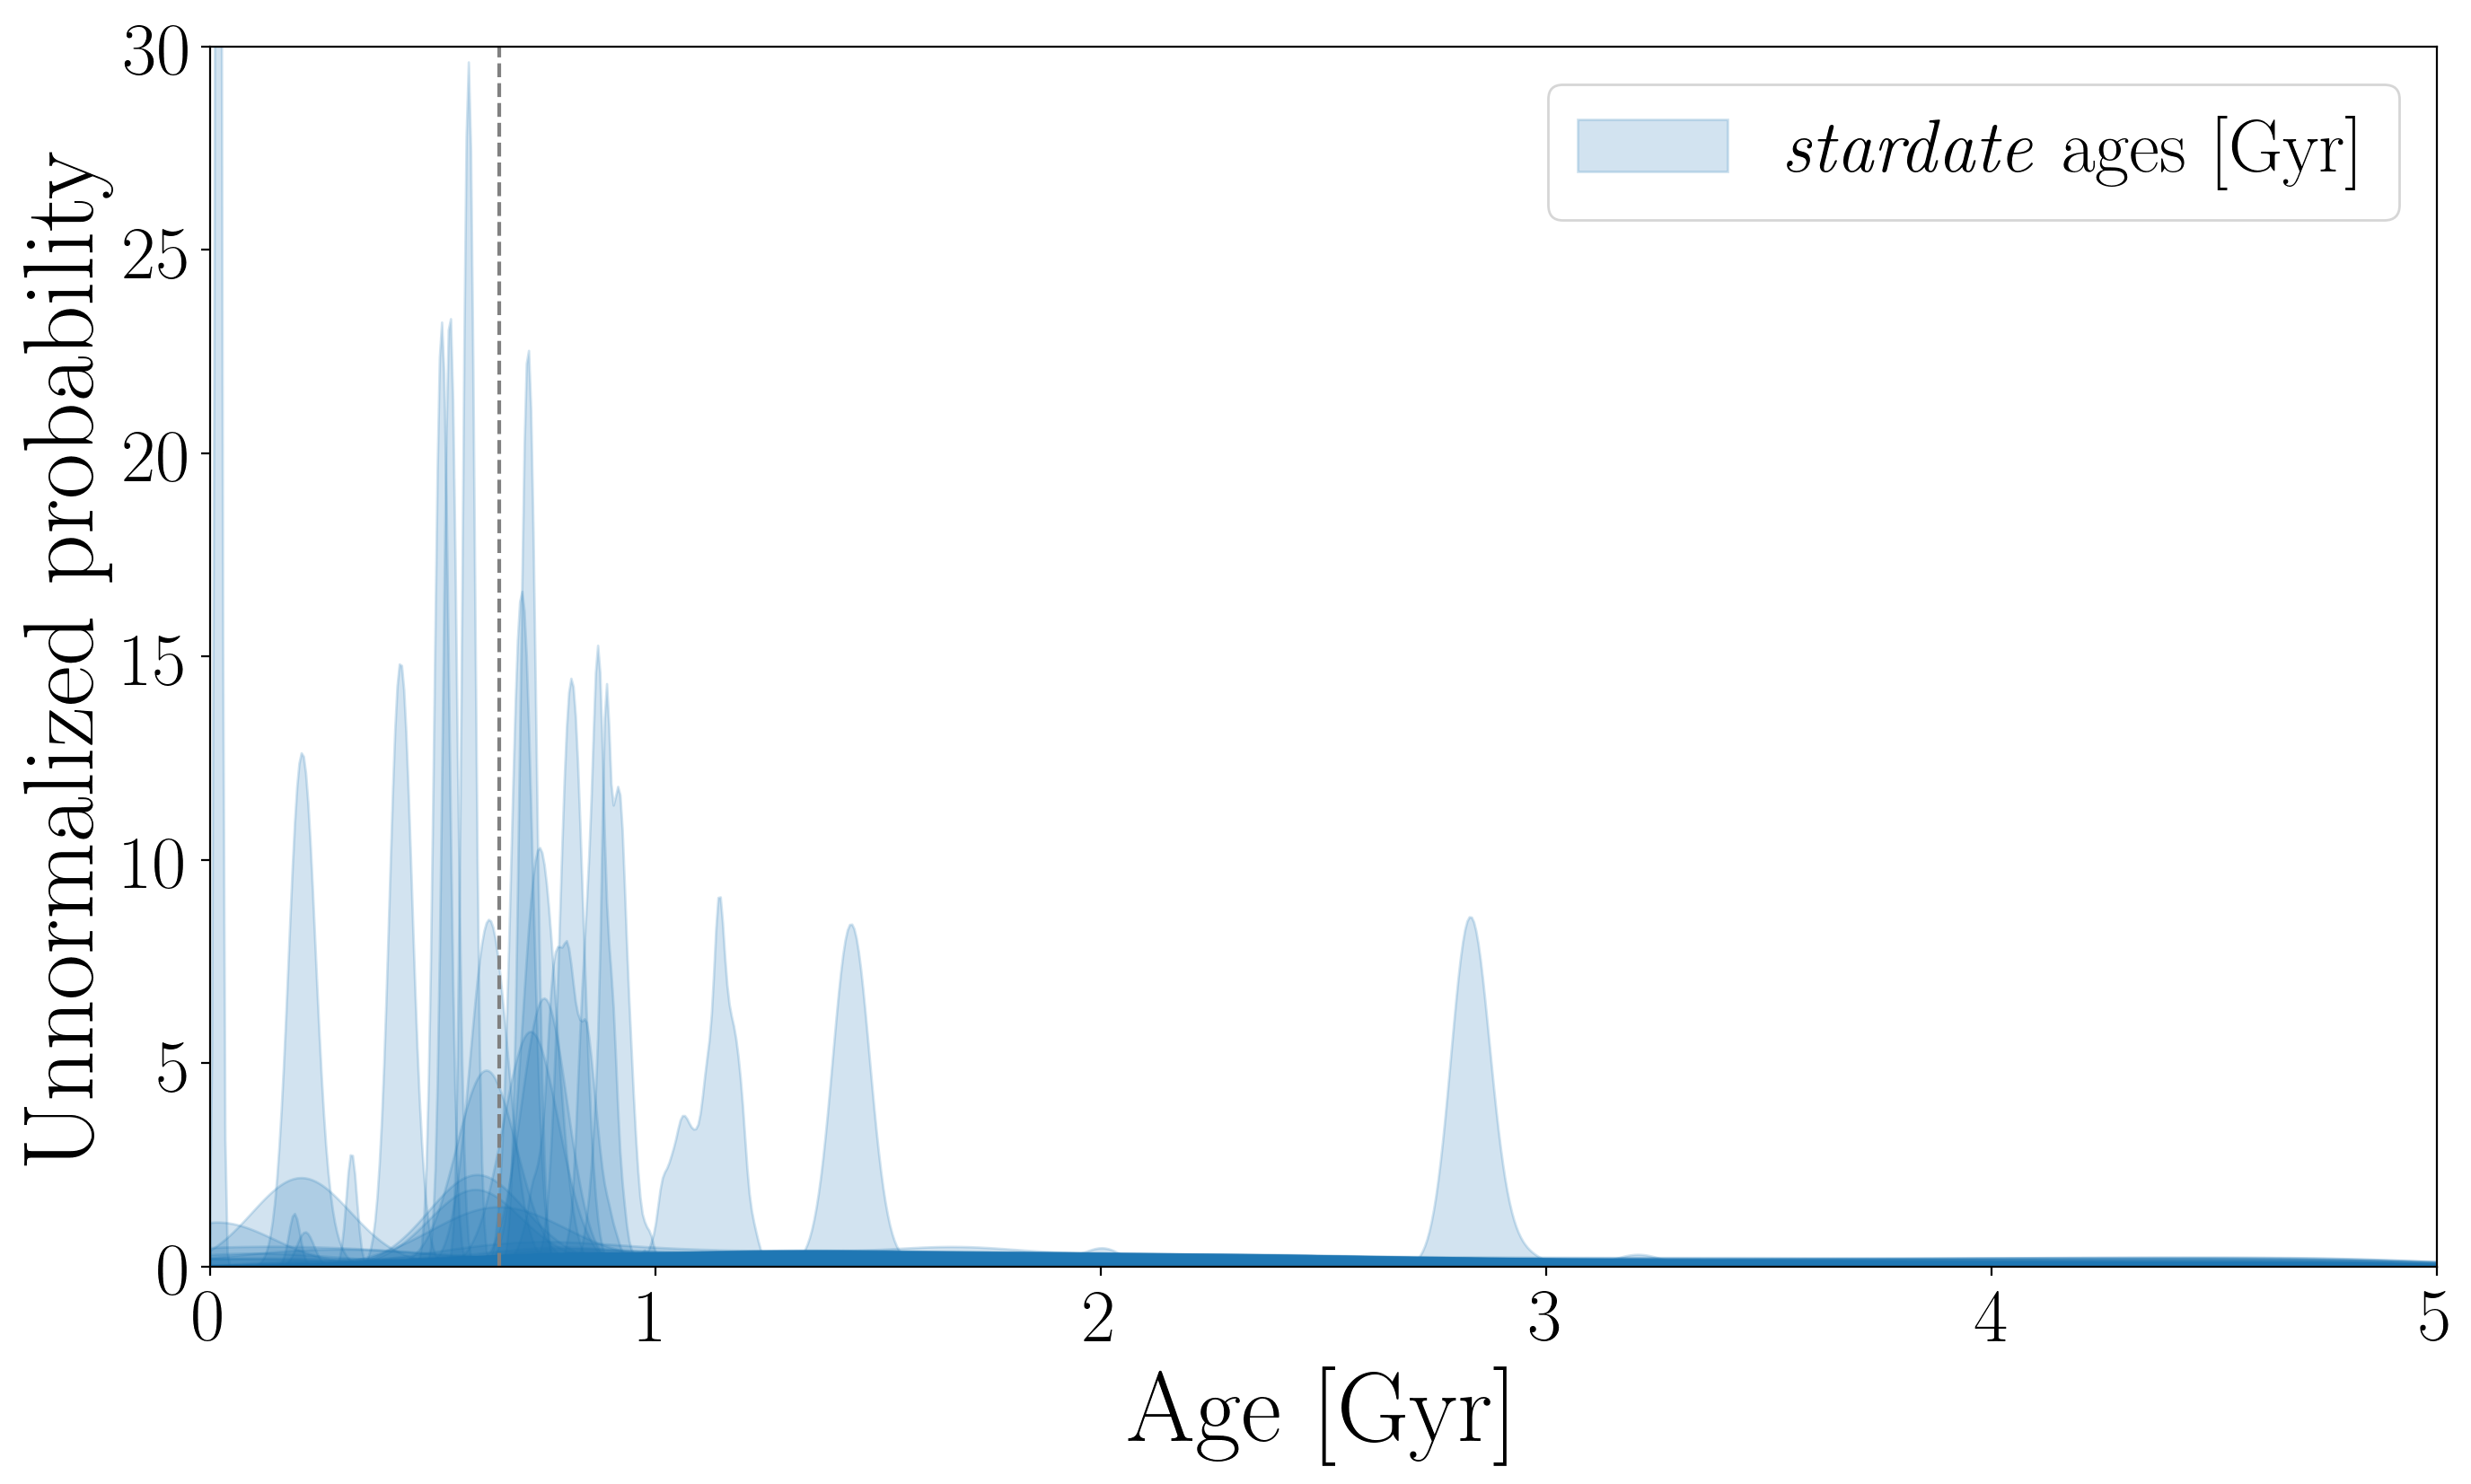

In [458]:
import scipy.stats as sps

xs = np.linspace(0, 5, 1000)

plt.figure(figsize=(16, 9), dpi=200)
    
# for i in gdf.i.values:
#     mask = np.array(pgage_samps)[i] < 5
#     kernel = sps.gaussian_kde(np.array(pgage_samps[i][mask]))
#     plt.fill_between(xs, 0, kernel(xs), color="C2", alpha=.1, zorder=0)    

# i = pdf.i.values[0]
# mask = np.array(page_samps)[i] < 5
# kernel = sps.gaussian_kde(np.array(page_samps[i][mask]))
# plt.fill_between(xs, 0, kernel(xs), color="C0", alpha=.2, zorder=1,
#                      rasterized=True, label="$\mathrm{{\it stardate}~ages~[Gyr]}$")

# for i in pdf.i.values[1:]:
#     mask = np.array(page_samps)[i] < 5
#     kernel = sps.gaussian_kde(np.array(page_samps[i][mask]))
#     plt.fill_between(xs, 0, kernel(xs), color="C0", alpha=.2, zorder=1,
#                      rasterized=True)

# i = idf.i.values[0]
# mask = np.array(piage_samps)[i] < 5
# kernel = sps.gaussian_kde(np.array(piage_samps[i][mask]))
# plt.fill_between(xs, 0, kernel(xs), color="C1", alpha=.5, zorder=2,
#                      rasterized=True, label="$\mathrm{Isochrone~ages~[Gyr]}$")
    
# for i in idf.i.values[1:]:
#     mask = np.array(piage_samps)[i] < 5
#     kernel = sps.gaussian_kde(np.array(piage_samps[i][mask]))
#     plt.fill_between(xs, 0, kernel(xs), color="C1", alpha=.5, zorder=2,
#                      rasterized=True)
    
plt.xlim(0, 5)
plt.axvline(.65, color=".5", ls="--")
plt.xlabel("$\mathrm{Age~[Gyr]}$")
plt.ylabel("$\mathrm{Unnormalized~probability}$")
plt.legend()
plt.ylim(0, 30)
plt.savefig("../praesepe_results.pdf")

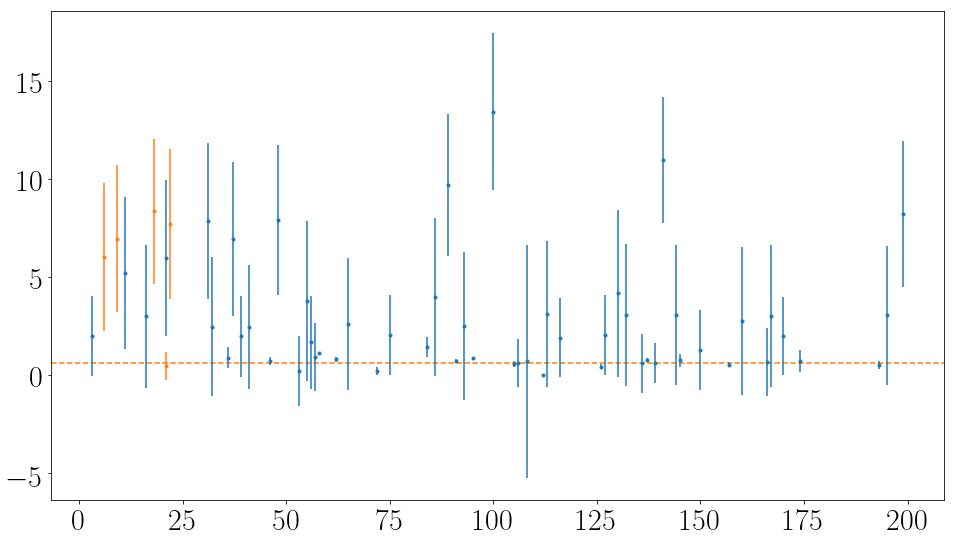

In [454]:
plt.figure(figsize=(16, 9))
plt.axhline(0.65, color="C1", ls="--", zorder=0)
for i, j in enumerate(pdf.i.values):
    plt.errorbar(j, pdf.age.values[i], yerr=pdf.age_err.values[i], fmt=".", color="C0", zorder=1)
    
for i, j in enumerate(idf.i.values):
    plt.errorbar(j, idf.age.values[i], yerr=idf.age_err.values[i], fmt=".", color="C1", zorder=1)
# plt.errorbar(np.arange(len(idf)), idf.age, yerr=[idf.age_errp, idf.age_errm], fmt=".", zorder=1)

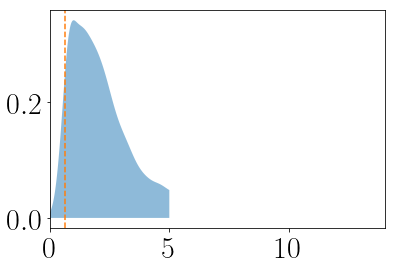

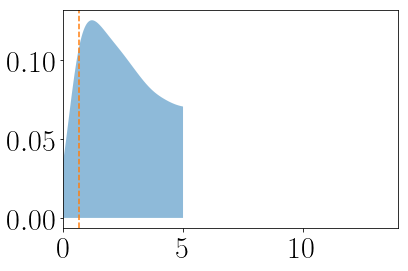

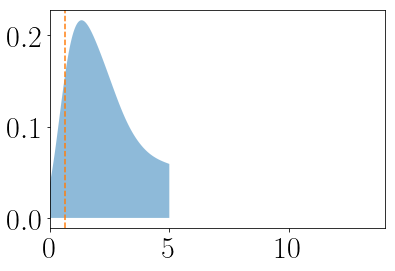

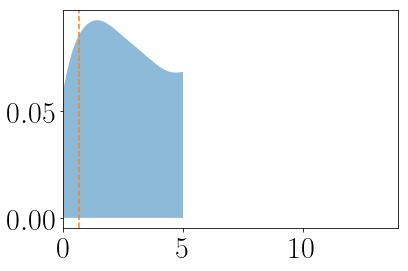

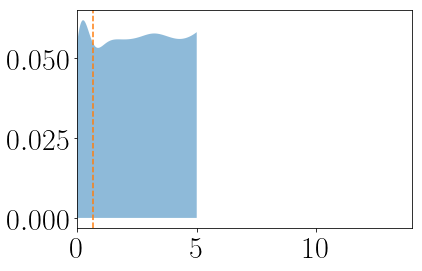

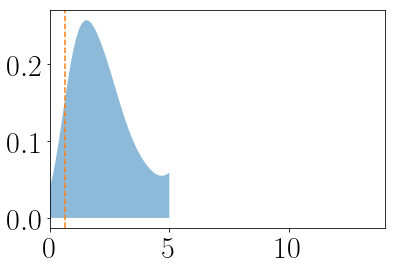

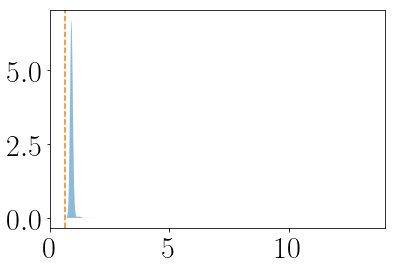

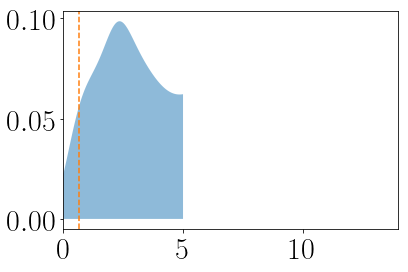

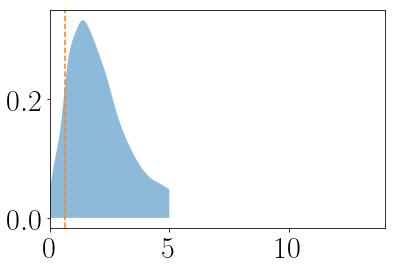

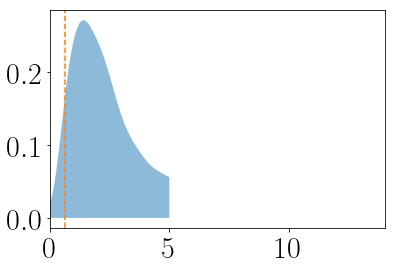

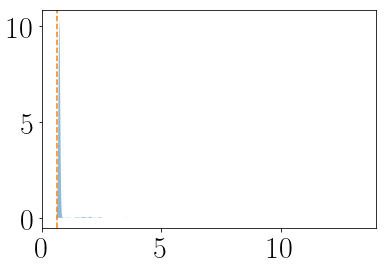

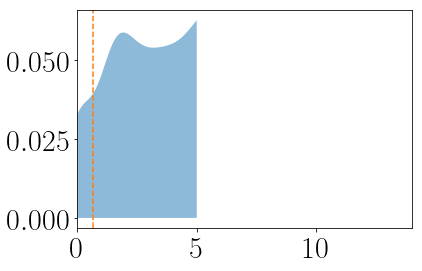

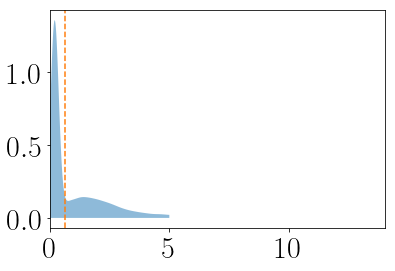

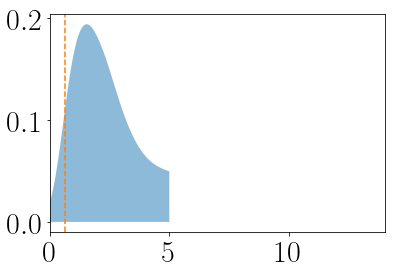

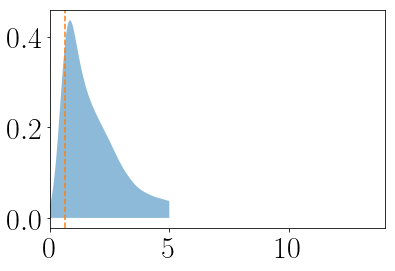

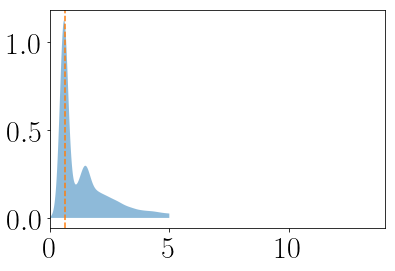

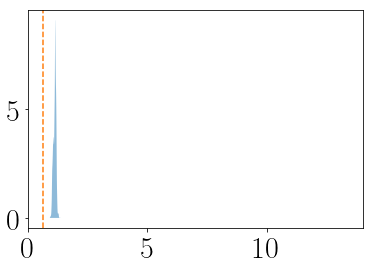

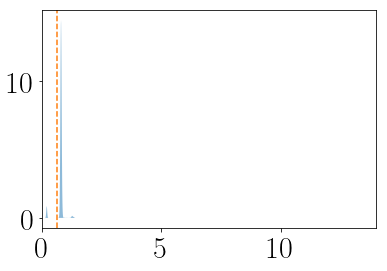

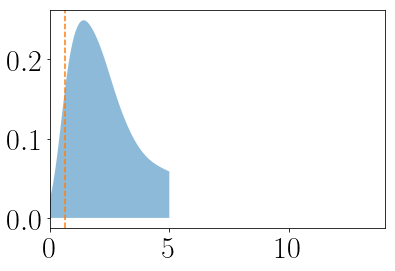

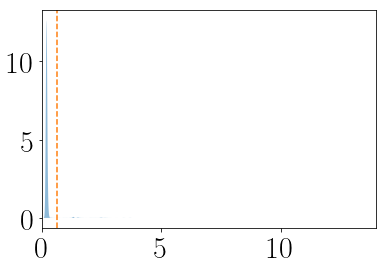

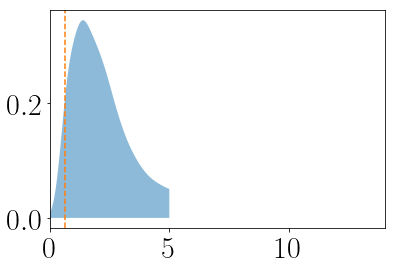

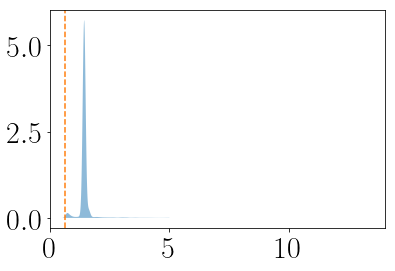

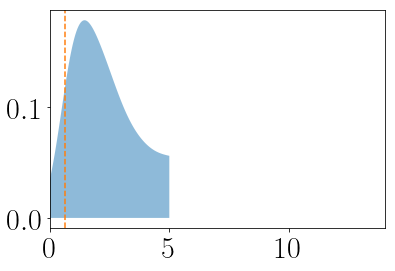

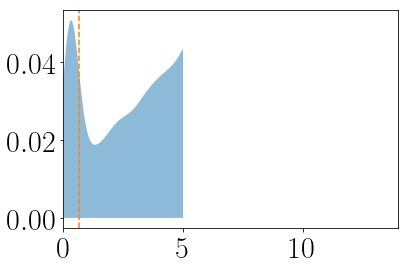

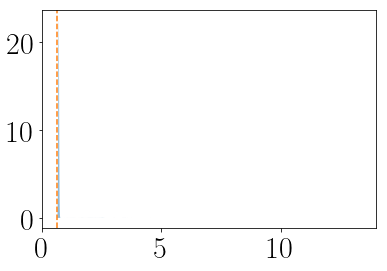

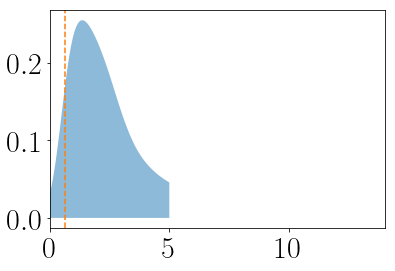

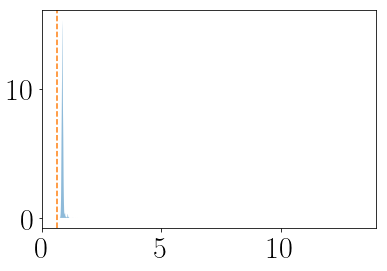

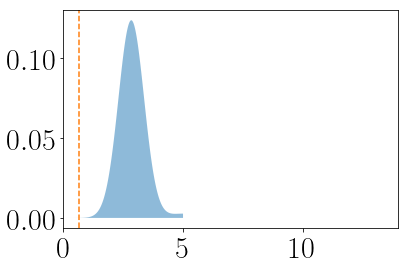

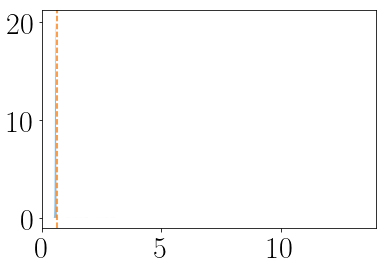

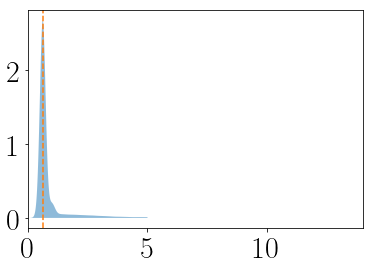

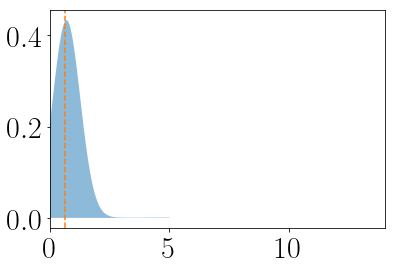

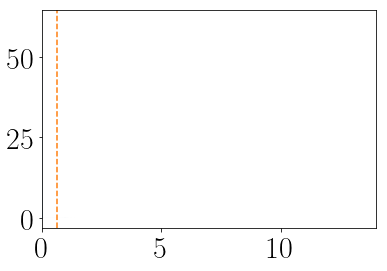

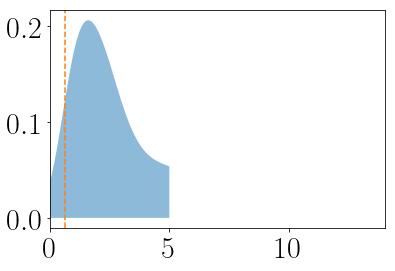

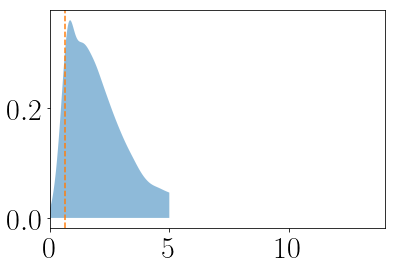

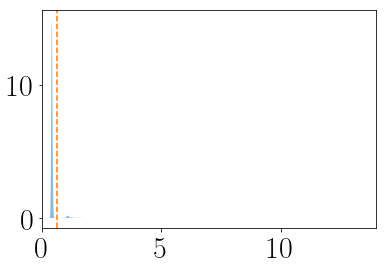

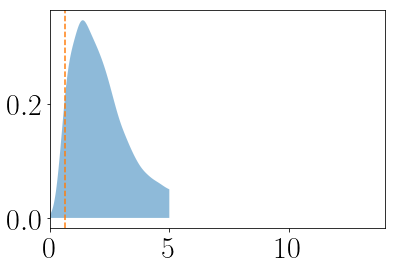

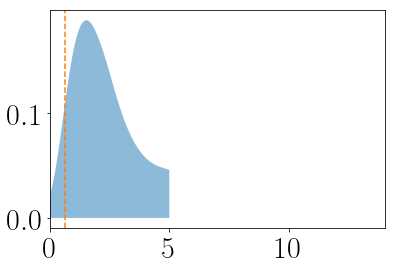

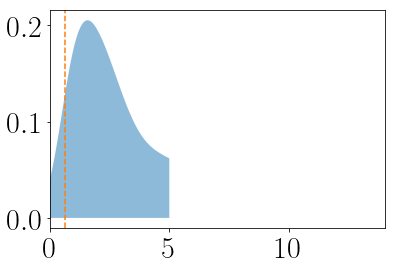

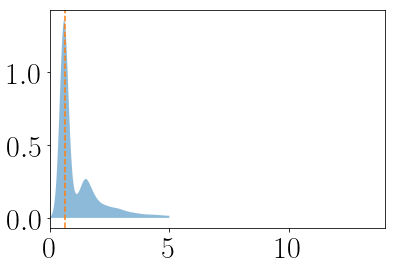

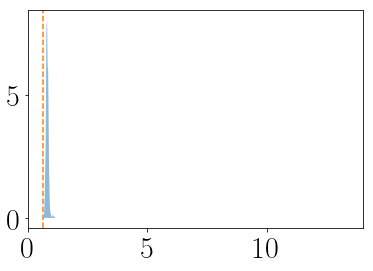

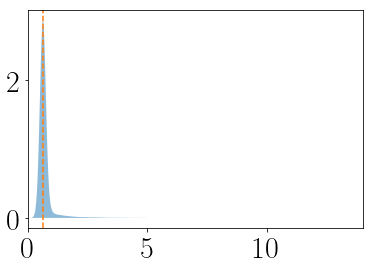

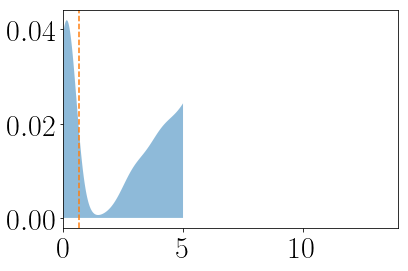

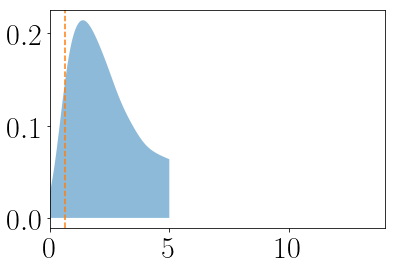

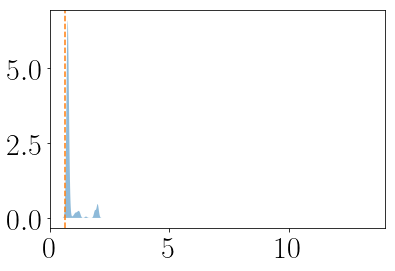

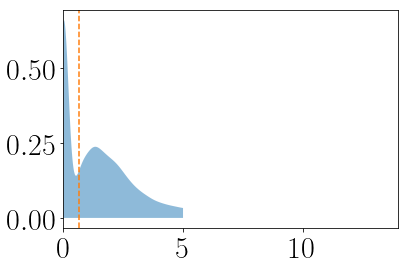

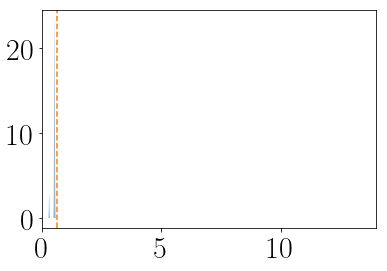

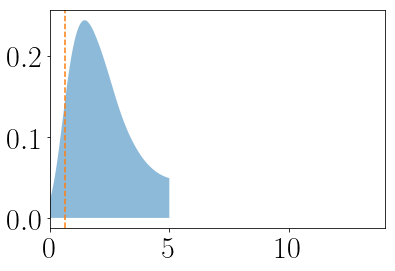

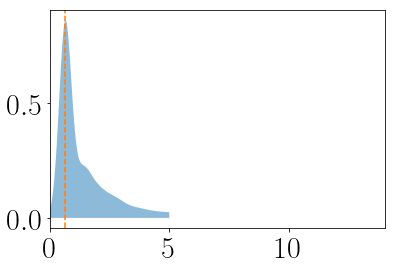

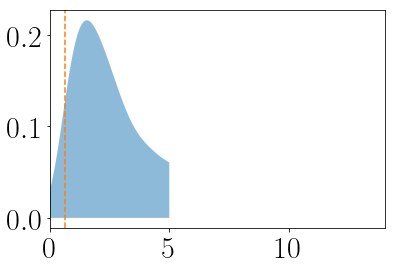

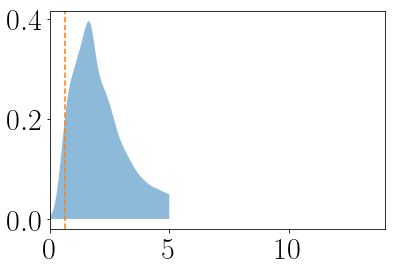

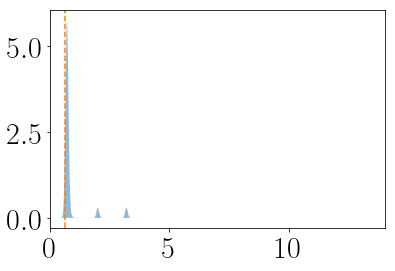

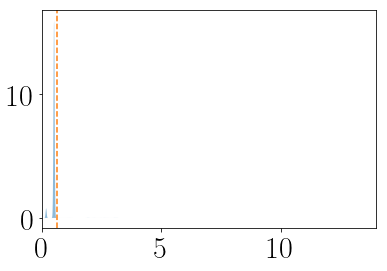

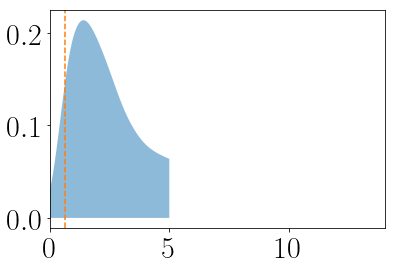

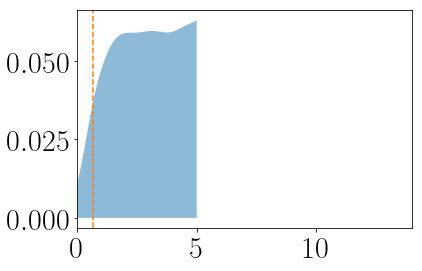

In [456]:
for i in pdf.i.values:
    kernel = sps.gaussian_kde(np.array(page_samps[i]))
    
    plt.subplot(1, 2, 1)
    plt.fill_between(xs, 0, kernel(xs), alpha=.5)
    plt.axvline(.65, color="C1", ls="--")
    plt.xlim(0, 14)
    
    plt.subplot(1, 2, 2)
    plt.show()

2.0523015832751508


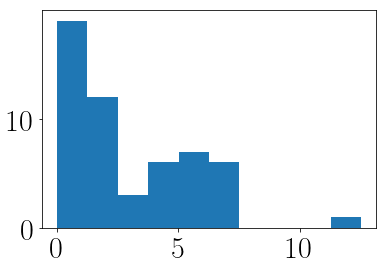

In [439]:
plt.hist(pdf.age_errp);
print(np.median(pdf.age_err))

0.008482478161804616


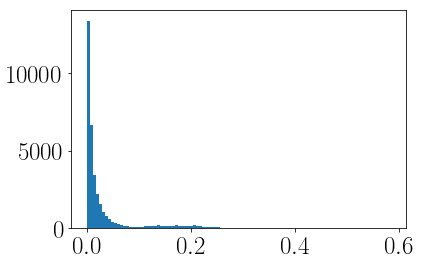

In [622]:
mc = pd.read_csv("data/Table_1_Periodic.txt")
plt.hist(mc.Prot_err/mc.Prot, 100);
print(np.median(mc.Prot_err/mc.Prot))
# plt.xlim(0, 25)

-2.0700714664284288
0.008509979885502093


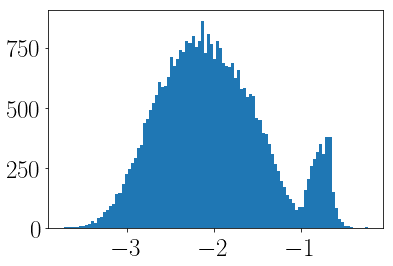

In [624]:
m = np.isfinite(mc.Prot_err/mc.Prot) * (mc.Prot_err/mc.Prot > 0.)
plt.hist(np.log10(mc.Prot_err[m]/mc.Prot[m]), 100);
print(np.median(np.log10(mc.Prot_err[m]/mc.Prot[m])))
print(10**np.median(np.log10(mc.Prot_err[m]/mc.Prot[m])))

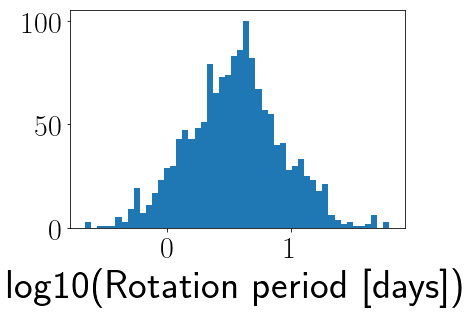

In [574]:
plt.hist(np.log10(mc.Prot.values[mc.Teff.values > 6250]), 50);
plt.xlabel("log10(Rotation period [days])")
plt.savefig("/Users/rangus/Desktop/period_distribution")

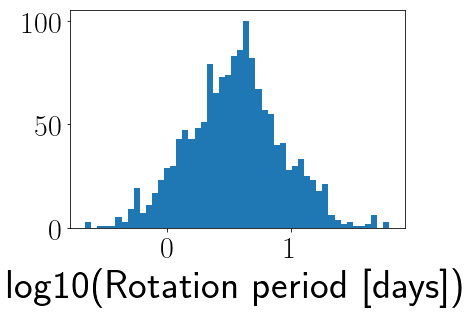

In [575]:
import pandas as pd
url = "https://arxiv.org/src/1402.5694v2/anc/Table_1_Periodic.txt"
mc = pd.read_csv(url)
plt.hist(np.log10(mc.Prot.values[mc.Teff.values > 6250]), 50);
plt.xlabel("log10(Rotation period [days])")

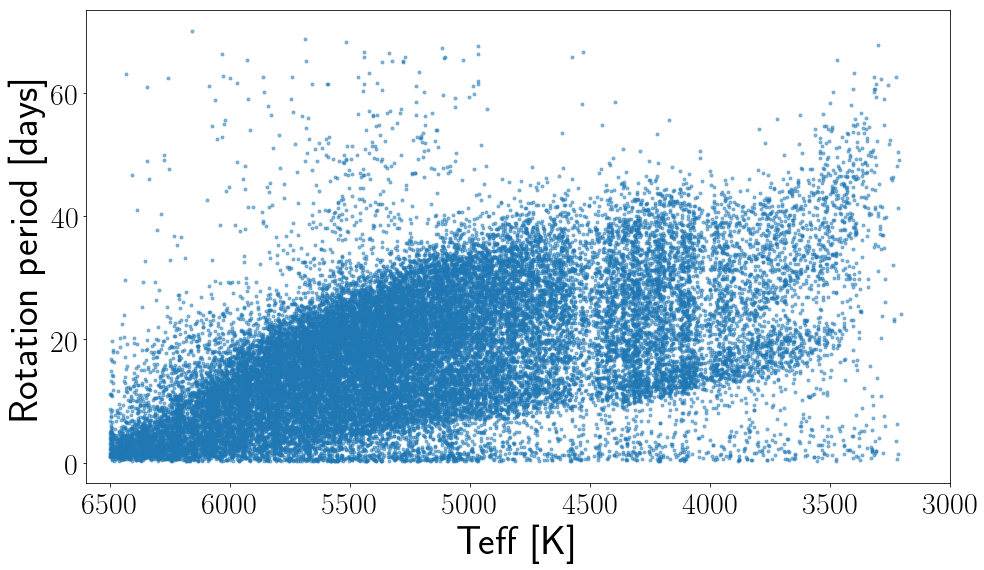

In [587]:
plt.figure(figsize=(16, 9))
plt.plot(mc.Teff, mc.Prot, ".", alpha=.5)
plt.xlim(6600, 3000)
plt.xlabel("Teff [K]")
plt.ylabel("Rotation period [days]")
plt.subplots_adjust(left=.15, bottom=.15)
plt.savefig("/Users/rangus/Desktop/period_teff")

In [200]:
def dist_mod(D):
    # m-M = 5*np.log10(D) - 5
    return 5*np.log10(D) - 5

print(dist_mod(1000))

10.0


In [203]:
import stardate as sd

# Create a dictionary of observables
iso_params = {"teff": (5777, 10),     # Teff with uncertainty.
              "logg": (4.44, .05),    # logg with uncertainty.
              "feh": (0., .001),      # Metallicity with uncertainty.
              "parallax": (1., .01),  # Parallax in milliarcseconds.
              "B": (15.48, 0.02),     # You must provide at least one magnitude.
              "maxAV": .1}            # Maximum extinction

prot, prot_err = 26, 1

# Set up the star object.
star = sd.Star(iso_params, prot=prot, prot_err=prot_err)  # Here's where you add a rotation period

# Run the MCMC
star.fit(max_n=10000)

# Print the median age with the 16th and 84th percentile uncertainties.
age, errp, errm, samples = star.age_results()
print("stellar age = {0} + {1} + {2}".format(age, errp, errm))

100%|██████████| 10000/10000 [01:13<00:00, 136.49it/s]

stellar age = 9.68645784464682 + 0.06717484438289034 + 0.08389554242028119
